<a href="https://colab.research.google.com/github/dan-a-iancu/airm/blob/master/ML_Pipeline/S11_12_Machine_Learning_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A Typical Machine Learning Pipeline: From Descriptive to Predictive**

This exercise will walk you through some of the typical steps that you would need to follow in a typical **Machine Learning Prediction** problem. We will be using the [California Housing Dataset](https://github.com/ageron/handson-ml2/tree/master/datasets/housing) to illustrate this: our task will be to **predict median house values in Californian districts** given a number of features from these districts. The dataset is a bit older and smaller than what you might encounter nowadays, but it serves as a very good pedagogical device. It has actually been featured in an excellent [recent book](https://github.com/ageron/handson-ml2) on machine learning in Python, and our notebook follows some of the developments there, but with a lot more guidelines to ensure a responsible implementation of the end-to-end ML pipeline.

______
<a id="basic_setup"></a>
# **Basic Setup**
The code below imports specific packages that define useful data-structures, objects and functions to manipulate these.

_**Please run this entire section by clicking the "Play" button.** No need to worry about understanding any of this code._

In [1]:
#@markdown Import revelant modules and define some useful functions
import os
import sys
assert sys.version_info >= (3, 5)   # Python ≥3.5 is required
import urllib

import numpy as np   # numpy for numerical linear algebra
import pandas as pd  # pandas for managing dataframes

#import tensorflow as tf
#from tensorflow.keras import layers

import sklearn
assert sklearn.__version__ >= "0.20"  # Scikit-Learn version ≥0.20 required
import sklearn.metrics as metrics

# adjust reporting in pandas: max 10 rows and two-digit precision
#pd.options.display.max_rows = 10
pd.options.display.float_format = "{:,.2f}".format

# import matplotlib and pyplot: critical packages for plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline  
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# install the latest version of seaborn for nicer graphics
!pip install seaborn==0.11.0  &> /dev/null
import seaborn as sns

# install facets overview
!pip install facets-overview &> /dev/null
# import facets overview + some other relevant packages
from IPython.core.display import display, HTML
import base64
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

# install graphviz for visualizing decision trees
!pip install graphviz  &> /dev/null
import graphviz

# install pdpbox for partial dependency visualization
!pip install pdpbox &> /dev/null
from pdpbox import info_plots, pdp

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

# Create a function to save figures to a desired local folder
FIGURE_FOLDER = "Figures"
FIGURE_PATH = os.path.join(".",FIGURE_FOLDER)
os.makedirs(FIGURE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIGURE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# A function to append dummies for specified variables -- this is done here because of some plotting routines
# returns the new dataframe and a dictionary with the categories for each categorical variable turned into a dummy
def append_dummies(data, columns):
  categories = {}  # the dictionary with categories
  data_with_dummies = data.copy() # the changed dataframe
  for col in columns:
    if col not in data.columns:
      print("WARNING. Column '{}' not among the columns in the dataframe. Skipping it.")
    elif (data[col].dtype!=int and data[col].dtype!=float):
      dummy_df = pd.get_dummies(data[col], prefix=col)
      categories[col] = list(dummy_df.columns)  # keep all the categories
      data_with_dummies = pd.merge( left=data_with_dummies, \
                                    right=dummy_df, \
                                   left_index=True, right_index=True,\
                                   how="inner", suffixes=("", "") )
  return data_with_dummies, categories

print("Success!")

Success!


_________
<a id="1"></a>
# **1. Download the Data**
You may need to download your data from some remote website repository or database such as Kaggle, Github, UCI, etc. Or alternatively, you may want to upload the data into Colab from a local file. Here, we will download our dataset as a CSV (comma separated value) file from a Github site, and save it to a local folder. If you have a local file you want to upload, you can uncomment the code to be able to load it into Colab.

_**Please run this entire section.** In practice, all you would need to do is change the URL below to point to the right website. If you already have your data stored locally in a suitable format (e.g., as a CSV or Excel file), you can skip this step._

In [2]:
#@markdown Download the data from the web and save it to a local CSV file
url = "https://raw.githubusercontent.com/dan-a-iancu/airm/master/ML_Pipeline/housing.csv"  # full URL to the dataset
local_csv = "housing.csv"   # name of local file where you want to store the downloaded file
aux = urllib.request.urlretrieve(url, local_csv)    # download from website and save it locally
print("Success!")

Success!


Alternatively, you can also upload the file into Colab from a local file. You can uncomment the next piece of code if you want to do that.

In [3]:
#@markdown Load the data from a local file on your computer
# from google.colab import files
# uploaded = files.upload()

___________
<a id="2"></a>
# **2. Load the Data and Take a Quick Look**
Read the dataset from a file into Python, and store it into a `pandas` DataFrame. You can think of a DataFrame as an Excel table with data organized by columns, where each row corresponds to a different **sample**.  

_**Please run this entire section.** We suggest expanding the cells to see how a DataFrame looks and to read some brief comments._


In [4]:
#@markdown Read the data from a CSV file into a `pandas` DataFrame
data = pd.read_csv(local_csv)

#@markdown Examine a few rows at the top 

#@markdown - select or type how many rows to display:
num_samp = "5" #@param [5, 10, 20] {allow-input:true}
num_samp = np.int(num_samp)

display(data.head(num_samp))

#@markdown Examine a few rows at the bottom
#@markdown - select or type how many rows to display:
num_samp = "5" #@param [5, 10, 20] {allow-input:true}
num_samp = np.int(num_samp)

display(data.tail(num_samp))

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...          452,600.00         NEAR BAY
1    -122.22     37.86  ...          358,500.00         NEAR BAY
2    -122.24     37.85  ...          352,100.00         NEAR BAY
3    -122.25     37.85  ...          341,300.00         NEAR BAY
4    -122.25     37.85  ...          342,200.00         NEAR BAY

[5 rows x 10 columns]

longitude  latitude  ...  median_house_value  ocean_proximity
20635    -121.09     39.48  ...           78,100.00           INLAND
20636    -121.21     39.49  ...           77,100.00           INLAND
20637    -121.22     39.43  ...           92,300.00           INLAND
20638    -121.32     39.43  ...           84,700.00           INLAND
20639    -121.24     39.37  ...           89,400.00           INLAND

[5 rows x 10 columns]

Note that each sample (i.e. row) in our data contains information on one district in California. The very first column in the table above is not an actual data field, but rather a unique index to identify the sample/row -- this was automatically introduced when we read our data in Python, and it makes it easy to refer to each sample. Our actual dataset has 10 columns, corresponding to the columns above that have headers. The first 9 seem to have **numeric** values, and `ocean_proximity` looks like a text and seems to have repeated values, so it is likely **categorical**. 

__________
<a id="3"></a>
# **3. Understand the Context**
Before diving in, it is very important to gain as much clarity about the context as possible. Some critical questions to consider:
  * **What type of data is available?** (Specifically, obtain a complete **data dictionary** that explains each field, and check you data against it.)
  * **How was the data collected and processed?**  (By whom, what methods, was there any pre-processing done?)
  * **What is the immediate prediction problem to solve?** (What is the precise **predicted quantity** and what kind of prediction problem is this?)
  * **How are the model's predictions going to be used?**  (Context is critical to avoid pitfalls related to privacy, legal issues, biases, etc.)

_To see more details about these issues and answers in our specific case, expand the hidden cells._

Before starting out, one needs as much clarity as possible about the  data and the (end) purpose of the ML project, which will also help with planning some of the subsequent steps. A few of the things to be aware of:  
  * **What data are available?**  
      - Make sure to obtain a **data dictionary** that describes all the available data fields.  
    <font color=blue>Our data fields here have the following meaning:
    *   `longitude`: A measure of how far west a district is (higher value is farther west)
    *   `latitude`: How far north a district is (a higher value is farther north)
    *   `housingMedianAge`: Median age of houses within the district (lower number is a newer building)
    *   `totalRooms`: Total number of rooms within a district
    *   `totalBedrooms`: Total number of bedrooms within a district
    *    `population`: Total number of people residing within a district
    *    `households`: Total number of households within a district
    *    `medianIncome`: Median income for households within a district (measured in tens of thousands of US Dollars)
    *    `medianHouseValue`: Median house value in a district (measured in US Dollars). This is our **predicted variable** of interest.
    *    `ocean_proximity`: A variable that characterizes the location of the district with respect to the ocean/bay.</font>  

    <font color=red>**GOOD PRACTICE: you may want to check a few samples in your data against the data dictionary, to spot any inconsistencies.**</font>

  * **How was the data collected and processed?**  
     - Try to find out how the data was collected (by whom, what methods, etc.), and if any **censoring or pre-processing** occurred before you obtained it.  
     <font color=blue>Our dataset is based on information collected in the 1990 California census. Aurélien Géron (the author of an ML textbook) modified it by removing some entries and defining the variable `ocean_proximity`. For more details, you can read [here](https://github.com/ageron/handson-ml2/tree/master/datasets/housing).</font>

  * **What is the precise prediction problem to solve?**  
      - What is the **predicted quantity**?  
      <font color=blue>Our task here is to predict **median house values in districts in California** based on features of those districts.</font>  
      - Does the prediction require solving a **regression** or a **classification** problem?  
      <font color=blue>We want to predict the precise house value as a continuous number, so we are dealing with a **regression task**.</font>  

  * **How is the ML model going to be used?**  
    - Predictive ML models are often used as inputs into other quantitative models -- for instance, prescriptive models, like we saw with the Starbux minicase last time. So it is important to understand as much as possible regarding **how** your ML model will be used. This is critical for the design, (e.g., it can inform what features might be relevant to add, and also help you tweak your model's "goodness of fit" so it better matches the end purpose), and also to make sure you avoid any privacy or legal concerns (e.g., using features that may be protected).

**Vocabulary.** Different disciplines like to use different terms in the context of prediction tasks. For instance, you may see the **columns** referred to as **attributes**, **fields** or **variables** interchangeably. Similarly, you may see the **predicted variable** (i.e., the `median_house_value`) also referred to as the **output**, **target**, **label** or **dependent variable**, and the other attributes referred to as **predictors**, **features** or **independent variables**.

**Notation.** We may have to write a few formulas later, so it would be useful to have a bit of notation defined:
   - We will use $i$ to denote a sample/row in our data. The easiest way is to think of $i$ as the index of the row in the table above. For instance, $i=0$ refers to the first sample, $i=1$ refers to the second row, etc.
   - We will use $y_i$ to denote the value that our **target** (i.e., the `median_house_value`) takes in the $i$-th sample. For instance, $y_0 = 452,600$.
   - We will use $x_i$ to denote the value of a particular **feature $x$** in the $i$-th sample. For instance, if $x$ is `total_rooms`, then $x_{20635} = 1,665$.

# <font color = red>**TASK #2. Exploratory Data Analysis.**</font>
Using the information in the Notebook and in your Excel analysis, answer the following questions for each of the variables:
1. **Do you notice any pattern in the values of the variable?**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Are there missing values?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Are there unexpectedly high or low values?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Do some values occur more or less often than you would expect?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Do you see signs of skew?
2. **Is the pattern you are observing "robust"?**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Does it depend on the way in which you are visualizing the data?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Is it different than what you might expect? Do you think it represents reality?  
3. **Does the pattern have meaningful implications in the given prediction problem?**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Could it lead to over-representing or under-representing something?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Could it generate bias in the predicted values?
4. **Could using the variable for the given prediction task raise legal or privacy concerns?**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Does the variable directly or indirectly speak to [**protected characteristics**](https://www.equalityhumanrights.com/en/equality-act/protected-characteristics) such as age, gender, race/ethnicity, etc.?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Could there be privacy violations?  
5. **What can you say about the relationship of the variable with the target (`median_house_value`) or other variables**?<br></font>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Is there strong correlation?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Are the values related in some other way?   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *As you address item #5, bear issues #2-4 in mind as well*

_________________
<a id="4"></a>
# **4. Exploratory Data Analysis**
The next step is to start exploring your data through **summary statistics**, **visualizations**, and a **correlation analysis**. These kinds of **descriptive analytics** help you understand your data and how it relates to your prediction task, and also enable you to detect potentially problematic issues like missing or incorrect entries, censoring problems, protected or private data, etc.

*This is an important section, and we will be replicating some parts of the analysis in Excel. We suggest expanding the hidden cells and then choosing which sub-section to expand further.*

<font color=red>Some important questions and issues to bear in mind when auditing your dataset to ensure a **responsible** implementation:</font>
* **Do you notice any pattern for some of your variables?**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Are there missing values?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Are there unexpectedly high or low values?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Do some values occur more or less often than you would expect?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Do you see signs of skew?
* **Is the pattern you are observing "robust"?**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Does it depend on the way in which you are visualizing the data?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Is it different than what you might expect / does it represent reality?  
* **Does the pattern have meaningful implications in the given prediction problem?**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Could it lead to over-representing or under-representing some parts of the "real" data?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Could it generate bias in the predicted values?
* **Could using some variables in the given prediction task raise legal or privacy concerns?**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Do the variables directly or indirectly speak to [**protected characteristics**](https://www.equalityhumanrights.com/en/equality-act/protected-characteristics) such as age, gender, race/ethnicity, etc.?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Could using some data lead to privacy violations?  
* **How are the variables related to the predicted variable (target) or other variables**?<br></font>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Is there strong correlation?  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Are the values related in some other way?   

<a id="5-EDA1-Facets"></a>
## **Statistics and Visualizations** with Google's **Facets Overview**
The researchers at Google [PAIR](https://research.google/teams/brain/pair/) have developed a powerful open-source tool called [Facets](https://pair-code.github.io/facets/) that allows exploring the data through an easy-to-use graphical user interface. We can try using it on our dataset.

*Run and expand this entire sub-section. No need to understand any of the code - we will only rely on the output.*

In [5]:
#@title Visualize the Data in Facets

# generate the visualization
gfsg = FeatureStatisticsGenerator()

proto = gfsg.ProtoFromDataFrames([{'name': 'original_data', 'table': data}])
# uncomment next two lines if you want to visualize training & test sets
#proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': train_set},
#                                  {'name': 'test', 'table': test_set}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

The tool should hopefully be self-explanatory. Some small things to note:
  * using **Sort by**, you can sort features based on other criteria; specifically:
      - **Non-uniformity** can be useful to seeing which features are very skewed
      - **Amount missing/zero** can allow you to see the features with missing values
  * underneath **Chart to show**, there are two useful buttons:
      - you can see a histogram of the logarithm of the values 
      - you can see larger histograms by clicking on **expand** 


<a id="5-EDA-NutsBolts"></a>
## **Statistics and Visualizations** : Nuts & Bolts
Although the Facets tool is powerful and easy to use, it is important to understand at a deeper level some of the routine processes. This enables you to replicate the functionality (useful if you don't have access to Google's `tensorflow` package or even Python), scale it up (useful if your dataset has thousands of variables), and **avoid certain pitfalls** that can emerge in the process.

*There are many details here. As you start conducting <font color=red>**TASK #2**</font> below, you may want to expand certain sections here to compare outputs.*

In [6]:
#@markdown **Define various functions to help with visualizations**

#@markdown - A function for **simple visualizations** of one or more features with histograms/boxplots/countplots
def visualize_features(all_data, features, figsize=(6,6), num_plot='histogram', \
                       num_bins='auto', num_cols=3):

    # calculate how many figures are needed
    num_figs = len(features)
    num_columns = (1 if num_figs==1 else num_cols)
    num_rows = int(np.ceil(num_figs/num_columns))
    
    # one large figure with a common title
    fig = plt.figure(figsize=(figsize[0]*num_columns,figsize[1]*num_rows))
    
    # title for plot
    title = ''

    for i in range(num_figs):

      # Create figure
      plt.subplot(num_rows,num_columns,i+1)
      ax1 = plt.gca()
      ax1.grid(alpha=.5, linewidth=1)

      if( (all_data[features[i]].dtype == 'float') or (all_data[features[i]].dtype == 'int') ):
        # numeric feature 
        
        # plot the feature according to the option
        if( num_plot == 'histogram'):
          #title = "Histogram of {}".format(features[i])
          sns.histplot(data = all_data[features[i]], bins=num_bins, color="skyblue", ax=ax1).set_title(features[i])

        elif( num_plot == 'boxplot' ):
          #title = "Boxplot of {}".format(features[i])
          sns.boxplot(data = all_data[features[i]], color="skyblue", ax=ax1).set_title(features[i])
        plt.tight_layout()

      else:
        # categorical feature
        sns.countplot(data = all_data, x=features[i], palette="Blues", ax=ax1).set_title(features[i])
        plt.tight_layout()

    plt.tight_layout()
    # determine the title
    #tar_ylabel = '{}'.format(target_name) if target_name else 'target'
    #fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

    plt.show()

#
#
#@markdown - A function to visualize **average dependency** of one numeric feature as a function of two other features
def visualize_average_dependency(all_data_with_dummies, all_categories, \
                                 feature_y, feature_x1, feature_x2=None,\
                                 num_bins=10, uniform_bins=False, \
                                 show_outliers=False, figsize=(10,9)):
   
    # append to all categories a string for numeric categories
    all_feats = [feature_y, feature_x1]
    if feature_x2 != None:
      all_feats += [feature_x2]

    categ_for_infoplot = all_categories.copy()
    for feat_ in all_feats:
      if feat_ not in all_categories.keys():
        # just the names for numeric features
        categ_for_infoplot[feat_] = feat_

    if uniform_bins:
      grid_type='equal'
    else:
      grid_type='percentile'

    # do all the infoplots
    if feature_x2==None:
      # visualizing just two features, so a simple target_plot will do
      title = "Relation between target '{}' and feature '{}'".format(feature_y,feature_x1)
      subtitle = "The count/height of bars shows the number of samples where {} takes that value".format(feature_x1) +\
        "\n and the line plot shows the average value of the target."

      fig, axes, summary_df = \
      info_plots.target_plot(df=all_data_with_dummies, \
                            feature=categ_for_infoplot[feature_x1], \
                            feature_name=feature_x1, \
                            target=categ_for_infoplot[feature_y],\
                            num_grid_points=num_bins, grid_type=grid_type, \
                            percentile_range=None, \
                            grid_range=None, cust_grid_points=None, \
                            show_percentile=False, \
                            show_outliers=show_outliers, endpoint=True, \
                            figsize=figsize, ncols=2, \
                            plot_params={"title" : title, "subtitle": subtitle})
    else:
      # plotting y as color-coded, as a function of x1 and x2
      title = "Relation between target '{}' and features '{}' and '{}'".format(feature_y,feature_x1,feature_x2)
      subtitle = "The circle color shows the average value of the target" +\
        "\n and the circle size shows the number of samples."

      fig, axes, summary_df = \
      info_plots.target_plot_interact(df=data_with_dummies, \
                                      features=[categ_for_infoplot[feature_x1],categ_for_infoplot[feature_x2]], \
                                      feature_names=[feature_x1,feature_x2], \
                                      target=categ_for_infoplot[feature_y], \
                                      num_grid_points=[num_bins,num_bins], \
                                      grid_types=[grid_type,grid_type], \
                                      percentile_ranges=None, \
                                      grid_ranges=None, cust_grid_points=None, \
                                      show_percentile=False, \
                                      show_outliers=show_outliers, endpoint=True, \
                                      figsize=figsize, ncols=2, annotate=True, \
                                      plot_params={"title" : title, \
                                                    "subtitle" : subtitle})    
#
#
#
#@markdown - A complex function to visualize relationships among several features
def visualize_detailed_dependencies(all_data_with_dummies, all_categories, \
                                    target, feature, feature_color=None,\
                                    feature_breakdown=None, \
                                    plot_type='scatter', min_categ=5, orient=None,\
                                    figs_per_row=3, figsize=(10,9)):

    # check to see if there's a need to change the plot type
    if plot_type=='boxen':
        # check to make sure that either the target or one of the features is numerical with enough values
        if (target in data_categories.keys() \
            and feature in data_categories.keys() ) or \
            ( len(all_data_with_dummies[target].unique()) <= min_categ and \
             len(all_data_with_dummies[feature].unique()) <= min_categ ):
            # target and first feature are categorical or have very few values
            if feature_color in data_categories.keys() or \
            ( len(all_data_with_dummies[feature_color].unique()) <= min_categ):
              # second feature is also categorical or with very few values 
              # it means all features are categorical -> switch to countplot
              print('Target and all selected features are categorical or have very few values. Switching to a countplot.')
              plot_type = 'count'
            else:
              # third feature is numeric with enough values --> switch with first feature
              aux=feature
              feature=feature_color
              feature_color=aux

    if plot_type=='scatter':
        # simple scatter plot
        sns.relplot(data=data_with_dummies, x=feature, y=target, \
                    hue=feature_color, col=feature_breakdown, \
                    row=None, style=None, col_wrap=None, row_order=None, \
                    col_order=None, palette=None, hue_order=None, hue_norm=None, \
                    sizes=None, size_order=None, size_norm=None, markers=None, \
                    dashes=None, style_order=None, legend='auto', \
                    kind='scatter', height=figsize[1], \
                    aspect=figsize[0]/figsize[1], facet_kws=None, units=None)

    if plot_type=='count':
        sns.catplot(data=data_with_dummies, x=target, y=None,\
                    hue=feature, col=feature_breakdown, \
                    kind=plot_type, row=None, col_wrap=None, \
                    row_order=None, col_order=None, \
                    ci=95, n_boot=1000, units=None, seed=None, order=None, \
                    hue_order=None, height=figsize[1], aspect=figsize[0]/figsize[1], \
                    orient=orient, color=None, palette=None, legend=True, \
                    legend_out=True, sharex=True, sharey=True, \
                    margin_titles=False, facet_kws=None)

    if plot_type=='boxen':
        # check if the number of categories for the target is smaller than for the feature
        if( len(all_data_with_dummies[target].unique()) < \
           len(all_data_with_dummies[feature].unique()) ):
          orient='h'
        sns.catplot(data=data_with_dummies, x=feature, y=target, \
                    hue=feature_color, col=feature_breakdown, \
                    kind=plot_type, row=None, col_wrap=None, \
                    row_order=None, col_order=None, \
                    ci=95, n_boot=1000, units=None, seed=None, order=None, \
                    hue_order=None, height=figsize[1], aspect=figsize[0]/figsize[1], \
                    orient=orient, color=None, palette=None, legend=True, \
                    legend_out=True, sharex=True, sharey=True, \
                    margin_titles=False, facet_kws=None)     

#### Examine the Data Values
A good start is to check more carefully the kind of values that each attribute takes in the dataset.<br>
<font color=green>**EXCEL:** You can add a [**Filter**](https://support.microsoft.com/en-us/office/filter-data-in-a-range-or-table-01832226-31b5-4568-8806-38c37dcc180e#:~:text=Select%20any%20cell%20within%20the,filter%20criteria%20and%20select%20OK.) from the **Data** menu, and glance at the values for each field.</font>

In [7]:
#@title Information on data types

# take a look at the type of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The output above confirms how many samples/rows (under `RangeIndex`) and how many columns are in the dataset. From `Dtype`, you can see the **type** of data: columns 0-8 are `float64` values, which means they are _numeric_. `ocean_proximity` is reported as a Python `object`, which could mean a lot of things; but we already know from our data dictionary and from earlier output that it is a _categorical_ attribute. From `Non-Null Count`, you can see how many non-empty values there are for each feature. This reveals that the **`total_bedrooms`** feature has <font color=red>**missing values**</font> in some samples, which is very important information in practice.

You may also want to see particular samples/rows of your dataset to check or flag errors. For instance, you can use the code below to display all the rows where the value of a specific feature (i.e., column) satisfies some condition.

In [8]:
#@markdown Display the samples where a feature satisfies a certain condition

#@markdown Select a numeric feature and specify a minimum/maximum range of values

feature = "total_bedrooms" #@param ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

minimum_value = 1 #@param {type:"number"}
maximum_value = 1 #@param {type:"number"}

if data[feature].dtype=='int' or data[feature].dtype=='float':
  filter = ( data[feature]>=minimum_value ) & (data[feature]<=maximum_value )
else:
  filter = []

# locate all the rows with households = 1
data.loc[ filter ]

longitude  latitude  ...  median_house_value  ocean_proximity
16171    -122.50     37.79  ...          500,001.00         NEAR BAY

[1 rows x 10 columns]

In [9]:
#@markdown Display all samples with missing values for `total_bedroom`
data.loc[ data['total_bedrooms'].isna() ] 

longitude  latitude  ...  median_house_value  ocean_proximity
290      -122.16     37.77  ...          161,900.00         NEAR BAY
341      -122.17     37.75  ...           85,100.00         NEAR BAY
538      -122.28     37.78  ...          173,400.00         NEAR BAY
563      -122.24     37.75  ...          247,100.00         NEAR BAY
696      -122.10     37.69  ...          178,400.00         NEAR BAY
...          ...       ...  ...                 ...              ...
20267    -119.19     34.20  ...          220,500.00       NEAR OCEAN
20268    -119.18     34.19  ...          167,400.00       NEAR OCEAN
20372    -118.88     34.17  ...          410,700.00        <1H OCEAN
20460    -118.75     34.29  ...          258,100.00        <1H OCEAN
20484    -118.72     34.28  ...          218,600.00        <1H OCEAN

[207 rows x 10 columns]

#### Summary Statistics
Next, let's obtain some quick summary statistics.  
<font color=green>**EXCEL:** Recall that you can do this using [**Descriptive Statistics**](https://www.excel-easy.com/examples/descriptive-statistics.html) from the **Data Analysis** TookPak, under the **Data** menu.</font>

In [10]:
#@markdown  Take a look at summary statistics for numeric attributes
data.describe()

longitude  latitude  ...  median_income  median_house_value
count  20,640.00 20,640.00  ...      20,640.00           20,640.00
mean     -119.57     35.63  ...           3.87          206,855.82
std         2.00      2.14  ...           1.90          115,395.62
min      -124.35     32.54  ...           0.50           14,999.00
25%      -121.80     33.93  ...           2.56          119,600.00
50%      -118.49     34.26  ...           3.53          179,700.00
75%      -118.01     37.71  ...           4.74          264,725.00
max      -114.31     41.95  ...          15.00          500,001.00

[8 rows x 9 columns]

### Histograms and Boxplots for Numeric Features
You can often gain a lot more insight about the data by visualizing the entire distribution of values through **histograms** or **boxplots**.

<font color=green>**EXCEL:** You can create histograms and boxplots from  **Insert > Insert Statistic Chart** ([click here](https://support.microsoft.com/en-us/office/create-a-histogram-85680173-064b-4024-b39d-80f17ff2f4e8) for detailed instructions on histograms).</font>

<font color=red>**When building histograms, always remember to try different values for the number of bins or bin width**.</font><br> 
This is actually quite critical: a wrong choice can mislead by obscuring important patterns or by creating patterns out of pure randomness. Better packages try to come up with good default choices, but **you should never be over-reliant on automatic approaches, because they depend on particular assumptions about your data**. It is always best to check that whatever pattern you observe remains reasonably consistent as you change the bin number/width. Try changing this parameter below to see how the plots change.

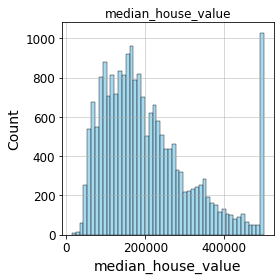

In [11]:
#@title **Plot histograms or boxplots for numeric features**

#@markdown Select which feature to visualize (picking **"All"** will plot histograms for all numeric features):
feature = "median_house_value" #@param ["All", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

if(feature=="All"):
  # all features except ocean proximity (which is categorical)
  feature = list(data.columns)  
  feature.remove("ocean_proximity")
else:
  feature = [feature]

#@markdown Choose what type of plot you want to see:
plot_type = "histogram" #@param ["histogram","boxplot"]

#@markdown <br><br>**Feel free to customize some elements of the plot (leave as "Auto" if unsure)**

#@markdown Choose or type how many figures to display per row:
figures_per_row = "5" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figures_per_row=="Auto":
  figures_per_row=4
else:
  figures_per_row=np.int(figures_per_row)

#@markdown Choose or type how many bins to use for the histogram:
num_bins = "50" #@param ["Auto",5,10,20,50,100]{allow-input: true}
if num_bins=="Auto":
  num_bins=10
else:
  num_bins=np.int(num_bins)

#@markdown Choose or type the width and height for each figure in inches:
figure_width = "4" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_width=="Auto":
  figure_width=5.0
else:
  figure_width=np.float(figure_width)

figure_height = "4" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_height=="Auto":
  figure_height=5.0
else:
  figure_height=np.float(figure_height)

# plot the feature(s)
visualize_features(all_data=data, features=feature, \
                   figsize=(figure_width,figure_height), num_plot=plot_type, \
                   num_bins=num_bins, num_cols=figures_per_row)

### Visualizing Geographic Data

If your data contains numeric attributes with geographic meaning, it may be very useful to try a different visualization  overlaid on top of actual maps. For instance, we can do a scatter plot of `latitude` and `longitude`, and overlay it on a map of California.

<font color=green>**EXCEL:** Apart from a scatter plot, you can also insert a Map in Excel from **Insert > 3D Map** ([click here](https://support.microsoft.com/en-us/office/get-started-with-3d-maps-6b56a50d-3c3e-4a9e-a527-eea62a387030) for detailed instructions).</font>

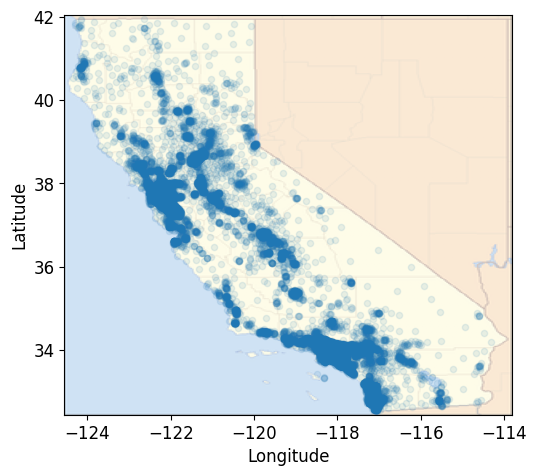

In [12]:
#@title Scatter plot of `latitude` and `longitude` on top of a map
import matplotlib.image as mpimg
map_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/California_Locator_Map.PNG/280px-California_Locator_Map.PNG"
california_img = mpimg.imread(map_url)

fig = plt.figure(dpi = 100,figsize = (5,5))
ax = fig.add_axes([1,1,1,1])

data.plot(kind="scatter", x="longitude", y="latitude", figsize = (8,4), ax=ax, alpha=0.1)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=12)
plt.xlabel("Longitude", fontsize=12)
plt.show()

To be able to get useful information from these scatter plots, you may want to play with the transparency of the markers, setting this to a lower value so that you can see areas with agglomerations. 

<a id="5d"></a>
### Categorical Attributes
Recall that our data also has a categorical field, `ocean_proximity`. For such fields, it is good to tabulate the values and create a count plot.

<font color=green>**EXCEL:** The most effective way to do this in Excel is by creating a **Pivot Chart** from the **Insert** menu ([click here](https://support.microsoft.com/en-us/office/create-a-pivotchart-c1b1e057-6990-4c38-b52b-8255538e7b1c) for detailed instructions).</font>

You can start by tabulating the values of the feature. This gives information similar to a histogram, recording all the values and their frequency.

In [13]:
#@title Tabulate the values of a categorical attribute
data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

For visualization, countplots can be very effective (they act essentially like histograms).

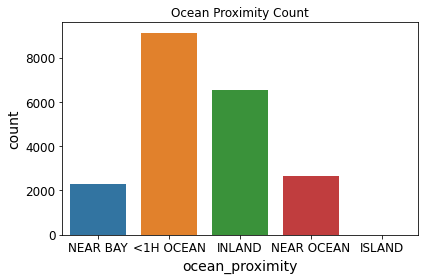

In [14]:
#@title Build a histogram / count plot for each categorical attribute
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="ocean_proximity", orient="v").set_title('Ocean Proximity Count')
plt.tight_layout()
plt.show()

<a id="5-EDA-Facets"></a>
## **Correlation Analysis** with Google's **Facets Dive**
We can again rely on Google PAIR's [Facets](https://pair-code.github.io/facets/) package, which provides an interactive tool called **Facets Dive** for visualizing **relationships** among features and even individual data points. When the dataset is large, it is best to use a **random sample** for the tool, as below.

*Run and expand this entire sub-section. No need to understand any of the code - we will only rely on the output.*

In [15]:
#@title Set the Number of Data Points to Visualize in Facets Dive

SAMPLE_SIZE = 5000 #@param
  
data_dive = data.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=data_dive)
display(HTML(html))

<a id="5B"></a>
## **Correlation Analysis** : Nuts & Bolts
For more flexibility and a deeper understanding of the processes, you could also take a step-by-step, do-it-yourself approach.

*There are many details here. As you conduct <font color=red>**TASK #2**</font>, you may want to expand some sections here to compare outputs.*

#### Correlation Coefficients
The starting point is to compute and visualize the **correlation coefficients** between the various **numeric** attributes. 

<font color=green>**EXCEL:** Recall that you can do this using [**Correlation**](https://www.excel-easy.com/examples/correlation.html) from **Data > Data Analysis**.</font>

Since the dataset is not large, we can obtain the entire matrix of correlation coefficients in Python in one shot with the `corr` method, and we can visualize it using the [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function in the `seaborn` package.

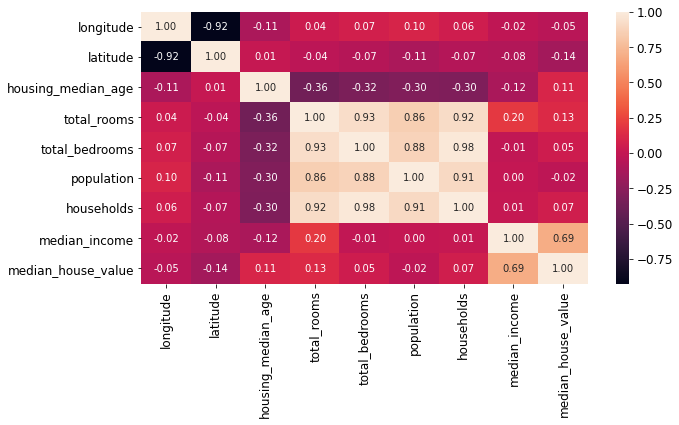

In [16]:
#@title Calculate and visualize the entire correlation matrix
# compute the matrix
corr_matrix = data.corr()

# plot the matrix as a heatmap
plt.figure(figsize = (10,5));
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

A critical thing to examine at this step is how each attribute correlates with the target `median_house_value`. You can read that information from above, but it's easier to display a sorted list of all the correlation coefficients.

In [17]:
#@markdown Display all the sorted correlation coefficients for `median_house_value`
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.00
median_income         0.69
total_rooms           0.13
housing_median_age    0.11
households            0.07
total_bedrooms        0.05
population           -0.02
longitude            -0.05
latitude             -0.14
Name: median_house_value, dtype: float64

#### Visualize Dependencies Through Plots (Scatter, Average Dependency)
An effective way to understand relationships between features is by visualizing them, e.g., through **scatter** or **average dependency plots**.

Your selections:
Main feature/target :   median_house_value
Feature_1 :             median_income
Feature_2 :             None
Plot type:              average_dependency


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


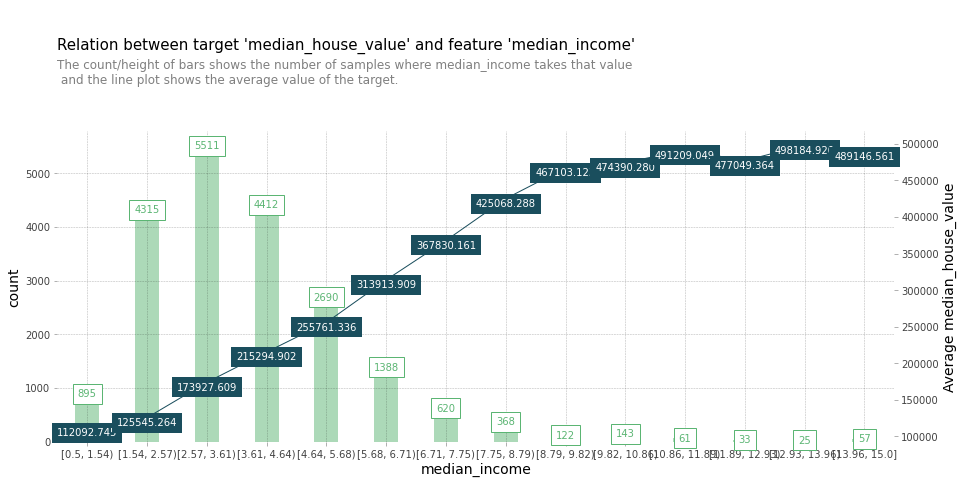

In [18]:
#@title Examine the relationships between features

# append dummies and store categories for all data (useful for plotting routines)
data_with_dummies, data_categories = append_dummies(data, data.columns)

#@markdown **Select the features to examine**

#@markdown The main feature for which you want to visualize dependencies:
main_feature = 'median_house_value' #@param ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value", "ocean_proximity"]

#@markdown Select another feature:
feature_1 = 'median_income' #@param ["None", "longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value", "ocean_proximity"]

#@markdown (Optional) Select a third feature to use for color-coding:
feature_2 = 'None' #@param ["None", "longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value", "ocean_proximity"]

#@markdown <br>**Select the type of plot to see**
#@markdown - **scatter** is the usual scatter plot you are familiar with
#@markdown - **average_dependency** displays the average value of the **`main_feature`**
plot_type = 'average_dependency' #@param ['average_dependency', 'scatter']

#@markdown **You can further customize some aspects of the plot**

#@markdown General settings:
#@markdown - **`fig_width`** : the width of each figure in inches (leave as **Auto** if unsure)
#@markdown - **`fig_height`** : the height of each figure in inches (leave as **Auto** if unsure)
fig_width = '15' #@param ['Auto']{allow-input : true}
fig_height = '8' #@param ['Auto']{allow-input : true}

#@markdown For an average dependency plot:
#@markdown - **`num_bins`** : the number of bins to use when discretizing a numeric feature
#@markdown - **`equal_count`** : whether to use bins with roughly equal counts/probabilities (unchecking this will generate bins with equal width)
num_bins = '15' #@param ['Auto']{allow-input : true}
equal_counts = False #@param {type:"boolean"}

# print the selections
print("Your selections:")
print("Main feature/target :  ", main_feature)
print("Feature_1 :            ", feature_1)
print("Feature_2 :            ", feature_2)
print("Plot type:             ", plot_type)

# set up parameters properly
if feature_2=="None":
  feature_2 = None

if fig_width=='Auto':
  fig_width=7.0
else:
  fig_width=np.float(fig_width)

if fig_height=='Auto':
  fig_height=7.0
else:
  fig_height=np.float(fig_height)

if num_bins=='Auto':
  num_bins=10
else:
  num_bins=np.int(num_bins)

if plot_type=='average_dependency':
    visualize_average_dependency(all_data_with_dummies=data_with_dummies,\
                                  all_categories=data_categories, \
                                  feature_y=main_feature, feature_x1=feature_1,\
                                  feature_x2=feature_2,num_bins=num_bins,\
                                  uniform_bins=(not equal_counts),\
                                  show_outliers=True,\
                                  figsize=(fig_width,fig_height))

else:
    if plot_type=='categorical':
        # check to make sure that either the target or one of the features is numerical
        if main_feature in data_categories.keys() and feature in data_categories.keys():
            # target and first feature are categorical
            if feature_2 in data_categories.keys():
              # second feature is also categorical; since the third feature 
              # is also categorical by choice, all are categorical -> switch to countplot
              print('Target and all selected features are categorical. Switching to a countplot of target.')
              plot_type = 'count'
            else:
              # feature_2 is numeric, will switch with feature_1
              aux=feature_1
              feature_1=feature_2
              feature_2=aux

    visualize_detailed_dependencies(all_data_with_dummies=data_with_dummies, \
                          all_categories=data_categories, \
                          target=main_feature, \
                          feature=feature_1, \
                          feature_color=feature_2,\
                          feature_breakdown=None,\
                          plot_type=plot_type,\
                          figs_per_row=3, figsize=(fig_width,fig_height))

# uncomment next line to save
#save_fig("scatterplot_of_{}_and_{}".format(feature1,feature2))

#### Geographical Features
For geographical attributes, we may want to rely on a different visualization by plotting feature values on top of a map.

<font color=green>**EXCEL:** Inserting maps in Excel from **Insert > 3D Map** can be **extremely** effective for this (click [here](https://support.microsoft.com/en-us/office/get-started-with-3d-maps-6b56a50d-3c3e-4a9e-a527-eea62a387030) for detailed instructions).</font>

We can plot two different numeric attributes on top of a map of California, with each data point given by a circle whose color captures one feature and whose width captures the other feature.

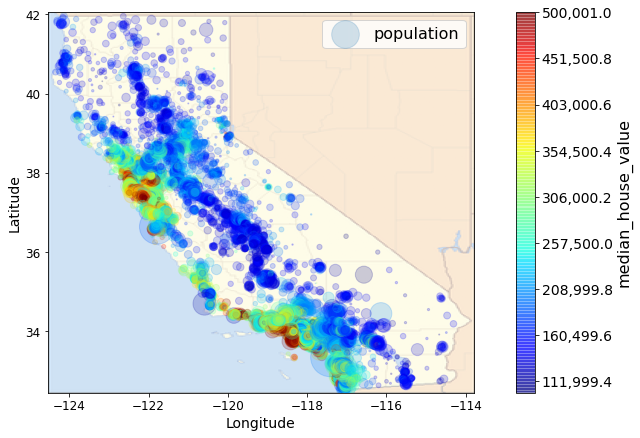

In [19]:
#@title Visualize two features on a map

#@markdown Pick the main feature to visualize using a color map:
main_feature = 'median_house_value' #@param ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

#@markdown Pick an additional feature to visualize by changing the size of bubbles:
extra_feature = 'population' #@param ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

#@markdown Optional: you can use **`min_value`** and **`max_value`** to filter which rows are shown based on the value of **`extra_feature`**:<br>
#@markdown (leave as **None** if you do not want to filter anything)

min_value = None #@param {type:"raw"}
max_value = None #@param {type:"raw"}

# adjust min and max if needed
minv = data[extra_feature].min()
maxv = data[extra_feature].max()

if( min_value is None):
  min_value = minv
elif( min_value > maxv ):
  print('Specified min_value of {} is above the maximum value in the data, which is {}. Setting min_value to minimum.'.\
        format(min_value,maxv))
  min_value = minv

if( max_value is None):
  max_value = maxv
elif( max_value < minv ):
  print('Specified max_value of {} is below the minimum value in the data, which is {}. Setting max_value to maximum.'.\
        format(max_value,minv))
  max_value = maxv

# filter based on the criterion
filtered_data = data[ (data[extra_feature] >= min_value) & (data[extra_feature] <= max_value) ]
if( len(filtered_data.index) == 0):
  print("Filter is too restrictive - there is no data to display. Removing filter.")
  filtered_data = data

import matplotlib.image as mpimg
map_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/California_Locator_Map.PNG/280px-California_Locator_Map.PNG"
california_img = mpimg.imread(map_url)

ax = filtered_data.plot(kind="scatter", x="longitude", y="latitude", figsize=(15,7),
                        s=filtered_data[extra_feature]/(filtered_data[extra_feature].median())*50, \
                        label=extra_feature, c="median_house_value", cmap=plt.get_cmap("jet"),\
                        colorbar=False, alpha=0.2)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], 
           alpha=0.5, cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

main_feature_vals = filtered_data[main_feature]
tick_values = np.linspace(main_feature_vals.min(), main_feature_vals.max(), 11)
cbar = plt.colorbar(ticks=tick_values/main_feature_vals.max())
cbar.ax.set_yticklabels(["{:,.1f}".format(v) for v in tick_values], fontsize=14)
cbar.set_label(main_feature, fontsize=16)

plt.legend(fontsize=16)
plt.show()

# uncomment next line to save
# save_fig("california_housing_prices_plot")

#### Categorical Features
For categorical features we cannot compute correlation coefficients, but we can rely on visualizations to understand the relationships. 

<font color=green>**EXCEL:** The most effective way to do this in Excel is by creating a **Pivot Chart** from the **Insert** menu ([click here](https://support.microsoft.com/en-us/office/create-a-pivotchart-c1b1e057-6990-4c38-b52b-8255538e7b1c) for detailed instructions).</font>

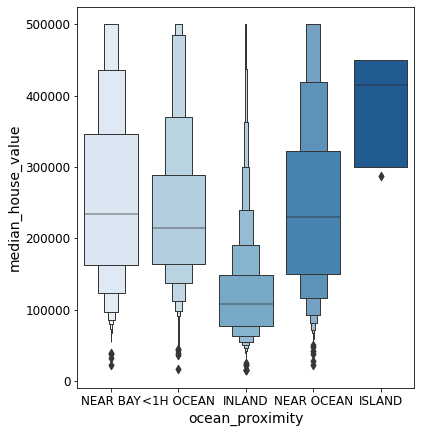

In [20]:
#@title Create boxenplots as a function of the categorical feature `ocean_proximity`

#@markdown **Select which numeric feature to visualize** (**All** will display all):
feature = "median_house_value" #@param ["All", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

#@markdown <br>**Feel free to customize some other elements of the plot** (leave as "Auto" if unsure)

#@markdown Choose or type how many figures to display per row:
figures_per_row = "5" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figures_per_row=="Auto":
  figures_per_row=4
else:
  figures_per_row=np.int(figures_per_row)

#@markdown Choose or type the width and height for each figure in inches:
figure_width = "7" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_width=="Auto":
  figure_width=7.0
else:
  figure_width=np.float(figure_width)

figure_height = "7" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_height=="Auto":
  figure_height=7.0
else:
  figure_height=np.float(figure_height)

if feature=="All":
  feature = list(data.columns)
  feature.remove('ocean_proximity')
else:
  feature = [feature]

num_figs = len(feature)
num_columns = figures_per_row
num_rows = int(np.ceil(num_figs/num_columns))

fig = plt.figure(figsize=(figure_width*num_columns,figure_height*num_rows))

for i in range(num_figs):
    plt.subplot(num_rows,num_columns,i+1)
    sns.boxenplot( x=data["ocean_proximity"], y=data[feature[i]], palette="Blues")  # a boxenplot

# Solution to <font color=red>**TASK#2**</font>

Click below to see a few of our insights and some additional observations emerging from this step of EDA.


#### **`longitude`** and **`latitude`**

**Regarding values**
- The histogram for each of these features seems to exhibit two peaks. Presumably these correspond to some densely populated areas, but it is hard to tell just from the histograms. A map visualization is more useful here, as it allows identifying locations with a higher density of points: you can see that these correspond to roughly 3 areas, and if you are familiar with California you may even identify these (the Bay Area to the north-west, the Los Angeles and San Diego areas to the south, and a long line east, near Sacramento and Fresno) 

- The map also reveals areas of California where your dataset has **very few samples**. This may reflect reality (there are fewer households there), but it could also reflect a <font color=black>**bias in data sampling**</font>, e.g., maybe the folks who collected the data never visited those areas! <br> <font color=red>**Always try to ensure that your data is as representative as possible of important classes that may be affected by the prediction.**</font> This is critical with protected characteristics, as it could lead to illegal discrimination. But it is important even with non-protected ones, because it can lead your ML algorithms to perform poorly for those classes. For instance, here, we may get very inaccurate predictions for house values drawn from such areas. 

- Additionally, some districts in our data also turn out to be very small, i.e., with very few households (we will talk about this more in our discussion **`total_bedrooms`**, **`total_rooms`**, and **`households`**). This means that using the location may generate <font color=red>**potential privacy concerns**</font>, as we may be able to **identify individual houses**. The same issue also arises with other features that may speak to private information, such as **median_income**. A potential way to correct for this is to aggregate such small districts together with other (nearby) districts into a single sample, but that obviously means there will be some loss of information.

**Regarding relationships**
- The features seem to be weakly correlated with our target **`median_house_value`**: correlation coefficients are -0.05 and -0.14, respectively. However, the scatter plots of house value against these features reveal important patterns, as there seem to be peaks in house values occuring at particular latitudes and longitude. Looking at the map figure makes this more clear: the peaks seem to occur exactly in some of the densely populated urban centers that we identified earlier, specifically the Bay Area in the North and the Los Angeles/San Diego area in the south. This makes intuitive sense, as densely populated areas may also command higher prices (also see the comments below for other features like `households` or `population`). So clearly geographical features are relevant for prices! But this also means that latitude and longitude by themselves may be poor predictors of median house values, but certain features derived from them may be valuable predictors; for instance, we could instead include a categorical variable capturing proximity to major urban areas. 

- Although the correlation coefficients are weak, `latitude` and `longitude` are also quite strongly related to other variables in our data, such as `median_income`, `households` and `population`. You may have noticed this when comparing the scatter plots of these variables against `latitude` and `longitude` (the location of the peaks was roughly **the same** as what we saw for `median_house_value`), or when plotting the various features on the map. This makes intuitive sense, as we might expect that in real life there is a concentration of wealth as well as population in certain areas, such as in densely populated urban centers. This also means that the information conveyed by the geographical features may already be captured by some of other variables.


#### **`housing_median_age`**

**Regarding values**
- The **`housing_median_age`** variable seems to take a maximum value of 52, and the histogram exhibits a sharp peak exactly at the value 52. This suggests that **the values for this feature may have been capped/censored**, i.e., any values exceeding 52 may have been recorded as 52. Having to work with pre-processed values is quite common and is not problematic in itself, but the context is critical to make a responsible determination. <font color=red>**Always try to understand how your data was collected and pre-processed, and whether that poses a problem.**</font> For instance, in our data we can observe the same censoring happening for our predicted variable **`median_house_value`**, which can be very problematic (read our discussion there). <br>
 **Note:** You may not have seen the sharp peaks in the histograms if you only used the Facets Tool, which draws a default histogram with 10 bins. This is why **drawing your own histograms is important!**

**Regarding relationships**
- This attribute seems to be weakly positively correlated with our target **`median_house_value`**: the correlation coefficient is 0.11. This may be a bit surprising, as one may expect newer constructions to be more expensive (holding everything else equal). But in reality, older houses may also be located in more desirable neighborhoods or may have certain design features that newer constructions don't have (e.g., high ceilings, charm), which may push prices higher. So the relationship between age and house value may be mixed.

#### **`total_rooms`,`total_bedrooms`,`households`, `population`**

**Regarding values**
- The **minimum values of these features are very small**, 1, 2 or 3. Either this is incorrect data or some districts are extremely small. To see what is happening more clearly, it is useful to filter the data based on a condition, as you did in <font color=black>**TASK 2** (A.2)</font>, where you probably noticed that indeed there is a district with just 1 household. This can lead to <font color=red>**potential privacy issues**</font>, because it means that our data may not be sufficiently annonymized, so our ML algorithms may be able to identify and discriminate based on information on unique households. <font color=red>**Always try to check if your data allows identifying individual protected characteristics.**</font> Whether this becomes a legal concern is context-dependent, and we will revisit these issues at length in a future class.

- You probably saw in <font color=black>**TASK 2** (A.2) that some districts are missing the value for **`total_bedrooms`**. <font color=red>**Missing or incorrect data**</font> issues occur very often in real-world datasets. Apart from revisiting the collection and recording process, there are a few other things you can do here, which we will discuss briefly in the section on preparing and cleaning your data.

- The histograms for all these features have a "heavy right tail", i.e., the values extend much farther to the right of the median than to the left. This kind of <font color=red>**skewed data**</font> may make it harder for some ML algorithms to detect patterns, so it may be useful to transform or rescale the features to have more "bell-shaped" distributions. This is something you would do at a later stage, when preparing your data.

**Regarding relationships**
- The target **`median_house_value`**  is weakly positively correlated with **`total_rooms`** and **`total_bedrooms`** (coefficients 0.13 and 0.05, respectively). This probably makes some sense if we expect "larger houses" to command larger prices; but remember that these features are recorded as total values **per district**, so it becomes less clear whether the relationship should be one of positive or negative correlation (also see the discussion below, for `households`). It would probably make more sense to consider new features corresponding to **rooms per household** for instance, as those would likely better predict house value. This is something you would usually do at a later stage of the ML pipeline, during **Feature Engineering**.<br>

- The target **`median_house_value`**  is very weakly correlated with **`households`** and **`population`** (coefficients 0.07 and -0.02, respectively). Here, it is not clear what one might expect. On the one hand, more densely populated areas such as large urban centers may command higher prices, which also seems to be the case in the map of California that we plotted. However, a larger population **in a district** may not necessarily be correlated with larger house prices (e.g., such neighborhoods may also be dirtier or have a higher crime rate). 

- These features are **very correlated among themselves**. This makes sense given that they are all related to total quantities per district. Strong correlation between predictive features may be undesirable as it can lead to multi-collinearity and it can make it hard to interpret the effects of individual features. It is good to be aware of these issues, and during the **Feature Engineering** stage you can try to define features that are less related among themselves but still correlated to the target.



#### **`median_income`**

**Regarding values**
- The values of this variable seem suspiciously small; in particular, it does not seem like the income is expressed in tens of thousands of US dollars, as our data dictionary claims. At this stage, it is probably useful to go back and check with the team that collected the data regarding any **processing or censoring** that may have taken place. For our purposes here, suppose that you are told that the data was scaled and capped at 15 (actually 15.0001) for higher incomes, and at 0.5 (actually 0.4999) for lower incomes.

- Somewhat relatedly, it is worth noting here that our numeric attributes have <font color=red>**very different value scales**</font>: some are expressed in thousands, some are less than 15. This can be problematic for certain ML algorithms, but can be easily fixed by re-scaling all the data.

- Since our dataset has districts with just one household, using the income may also result in <font color=red>**potential privacy concerns**</font>, as we can identify the income of a specific family. (In fact, this is one of the reasons why income values are censored both below and above for census collection purposes, so as to make it more difficult to identify potential outliers.)

**Regarding relationships**
- This variable is strongly positively correlated with the **`median_house_value`** target (coefficient 0.69), which can also be clearly seen in a scatter plot. This means that the `median_income` will likely be a good predictor, which also makes some sense in reality.

- Although income by itself is not likely a protected characteristic, it may heavily correlate with protected characteristics. So by using the income feature, the house value predictions from our ML algorithms may inadvertently be correlated with such protected characteristics, leading to <font color=red>**potential concerns of bias/discrimination**</font>. Whether that also results in legal or ethical issues is context-dependent, but it is important to be aware of the correlations in order to correct any issues, should they arise.

#### **`median_house_value`**

**Regarding values**
- Our target variable **`median_house_value`** seems to take a maximum value of \$500,001, and the histogram exhibits a sharp peak exactly at that value. This suggests that **the values for this feature may have been capped/censored**, i.e., any values exceeding \$500,001 may have been recorded as \$500,001. We saw this issue arising with the **`housing_median_age`** as well, and all the comments there also apply here.

This <font color=red>**censoring or pre-processing is particularly problematic**</font> here, because `median_house_value` is our predicted variable. Our ML algorithms may learn that prices never exceed \$500,001, but that is certainly not the case in reality, and would simply reflect poor data. You would need to check with your clients or the user of your system to see if this is a problem. If intended use cases require precise predictions beyond \$500,001, then you have two options: **(a)** collect proper values for the districts whose labels were capped, or **(b)** remove those districts from your data and clearly document that your system is only intended to predict house values below \$500K.

#### **`ocean_proximity`**

**Regarding values**
- `ocean_proximity` has a **very uneven distribution**: the vast majority of the data is either `<1H OCEAN` or `INLAND`, a few records are `NEAR OCEAN` or `NEAR BAY`, and extremely few records are listed as `ISLAND` (a histogram may actually be deceiving here as it could suggest zero records, so it is better to look at the counts). This may be a case of <font color=red>**biased data sampling**</font>, and it means that your ML algorithms are not likely to perform well for districts on islands. In addition to trying to collect more data or removing those districts altogether, we could also try to re-define the categories, e.g., by aggregating `ISLAND` and `NEAR OCEAN` into a single group.

**Regarding relationships**
- this feature seems to matter for house values: houses that are on an island seem to have higher value than those that are near the bay/ocean, and houses that are `INLAND` seem to have the lowest value. However, this feature is likely also very correlated with the geographical information in latitude and longitude.

# <font color = red>**TASK #3. Steps to prepare the data.**</font>
<font color=purple>**Conduct the following Analysis:**</font>
1. Create a **random split** of your dataset into 80% for training and 20% for testing, using a **seed of 123**.
2. Replace all the missing values of `total_bedrooms` with the median **calculated in the training set**. 
3. Transform the categorical variable `ocean_proximity` into **dummy variables** and delete the column corresponding to `INLAND`.

__________
<a id="5"></a>
# **5. Split the Data into a Training Set (80%) and a Test Set (20%)**
The next step is to split our data into two: a **training set** (typically 80% of the data), which we will use to estimate and calibrate our ML algorithms, and a separate **test set** (the remaining 20%), which we will use to assess performance after calibration. This practice is called **out-of-sample testing** or **cross validation**, and it is critical in a responsible evaluation of your system's performance. For those of you seeing it for the first time, it may see bizarre: *why would we voluntarily set data aside and not use it to train our algorithms?!* The reason is that we want to avoid having our algorithms learn to predict really well on our own data but fail miserably on new data -- a phenomenon known as **"overfitting"**. This is why from the get-go, we reserve and set aside some data for testing.

_**Please run this entire section.** If you would like to understand the issues at a deeper level, you can expand the sections and read through, particularly regarding how to avoid potential pitfalls like **sampling bias**._


### An 80-20 Random Split in Excel
<font color=green>**EXCEL:** You can do a random split in MS Excel using the [**Random Number Generation**](https://bettersolutions.com/excel/add-ins/analysis-toolpak-random-number-generation.htm) feature from **Data > Data Analysis**. We will do this together in class, but for complete instructions you can expand the hidden cells below and read the first sub-section.</font>

*Expand this section for detailed instructions and steps.*

1. Use [**Random Number Generation**](https://bettersolutions.com/excel/add-ins/analysis-toolpak-random-number-generation.htm) to produce a uniformly distributed random value for each sample in your data.  
 * Navigate to **Data > Data Analysis** and select **Random Number Generation**  
 * Under **Number of Variables**, type 1  
 * Under **Number of Random Numbers**, type the number of samples in your data (20640 for the California Housing Set)  
 * Under **Distribution**, choose **Uniform**, and you can leave the **Parameters** to the default values (0 and 1)  
 * Under **Random Seed**, type a specific value. <font color=red>For our class purposes, use a seed of **123** to ensure that you obtain the same random split in Excel as we use subsequently in our Python code.</font>
 * Under **Output Range**, select **New Worksheet Ply**, and give the new sheet a good name such as *training_set*.
 * Hit **Enter** or press **OK**.
 * Go to the new sheet, where you will see all the random values generated in column A, and insert one additional row just above the values (i.e., row 1). The values should now be stored in cells A2:A20641.

2. **Copy** your entire dataset (including the column with indexes for the samples, the header, and all the rows), and **paste** the values in the new sheet where you have the random values, starting with column **B**, i.e., immediately to the right of the column with random values.<br>_In our example, this means copying the data from cells `A1:K20641` or the original sheet and pasting it into cells `B1:L20641` of the new sheet._

3. **Add a filter** to the entire table of data in the new sheet.
 * From **Data**, select **Filter**; you should see buttons with down arrows added to each column. 
 * It may happen that Excel refuses to include column A (with the random values) into the filter together with the new columns. If that is the case, you can always extend the table from **Table Design > Resize Table**.

4. Sort the entire table based on the random values in column A.
 * Click on the down arrow for column **A**, and select a sorting method. _Use **Sort Smallest to Largest** to get the same values as we did._

5. Remove the filter and delete column **A**. 
 * Go to **Data** and click on **Filter** again; you should no longer see the buttons with down arrows.

6. You now have a dataset that contains exactly the same samples/rows as our original dataset, but with the samples in a permuted order. You can simply keep the first 80% of the rows (i.e., rows 2-16513) in the new sheet you generated, and **cut and paste** the last 20% of the samples (i.e., rows 16514-20641) into a separate sheet for the **test set**. You may also want to copy the headers with the column names into this new sheet.

### An 80-20 Random Split in Python



We will use the `Scikit-Learn` package to automate this, and we will set a "seed" for the random number generator (here, the value 42) to ensure that we would get the same train/test split if we repeated the process.

In [21]:
#@markdown Create an 80-20 random split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

Let's have a quick look at the two datasets.

In [22]:
#@markdown Print a few samples from the top of the training set
train_set.head()

longitude  latitude  ...  median_house_value  ocean_proximity
14196    -117.03     32.71  ...          103,000.00       NEAR OCEAN
8267     -118.16     33.77  ...          382,100.00       NEAR OCEAN
17445    -120.48     34.66  ...          172,600.00       NEAR OCEAN
14265    -117.11     32.69  ...           93,400.00       NEAR OCEAN
2271     -119.80     36.78  ...           96,500.00           INLAND

[5 rows x 10 columns]

In [23]:
#@markdown Print a few samples from the top of the training set
test_set.head()

longitude  latitude  ...  median_house_value  ocean_proximity
20046    -119.01     36.06  ...           47,700.00           INLAND
3024     -119.46     35.14  ...           45,800.00           INLAND
15663    -122.44     37.80  ...          500,001.00         NEAR BAY
20484    -118.72     34.28  ...          218,600.00        <1H OCEAN
9814     -121.93     36.62  ...          278,000.00       NEAR OCEAN

[5 rows x 10 columns]

The simple procedure that we described here should work reasonably well if our dataset is large enough, particularly relative to the number of attributes. But in practice, that may not always be the case, and two potential pitfalls could occur:
  - When the data is not **very large**, we may run the risk of introducing **sampling bias**, which is a form of **selection bias**. This means that the training or test set may not adequately represent our full data, and can be a very serious issue in practice. It is important to avoid it by using **stratified sampling**, which we discuss next.
  - We may want to ensure that even if we append new data to our dataset and do a new split (on the bigger dataset), the current training (respectively, test) set continues to be a part of the future training (respectively, test) set. This can be done by creating a unique ID for each data point and using those IDs to decide if a point goes in the training or test set. We omit further details here.

### Use the Same Split as in Excel
For the rest of our exercise, we would like to ensure that the results in Python are the same as those obtained in Excel, so we will read the random sample from an Excel file where we used the same random seed of **123**.

In [24]:
#@markdown Read the train-test split obtained in Excel
url_train = 'https://raw.githubusercontent.com/dan-a-iancu/airm/master/ML_Pipeline/housing_training_set.csv'
url_test = 'https://raw.githubusercontent.com/dan-a-iancu/airm/master/ML_Pipeline/housing_test_set.csv'

train_set = pd.read_csv(url_train, index_col=0)
test_set = pd.read_csv(url_test, index_col=0)

In [25]:
#@markdown Check the first few samples in the training set
train_set.head()

longitude  latitude  ...  median_house_value  ocean_proximity
Index                       ...                                     
2527     -122.20     39.53  ...               71000           INLAND
12116    -117.23     33.96  ...              163300           INLAND
12443    -115.22     33.54  ...               53500           INLAND
8494     -118.30     33.90  ...              181400        <1H OCEAN
5455     -118.46     34.01  ...              297200        <1H OCEAN

[5 rows x 10 columns]

In [26]:
#@markdown Check the first few samples in the test set
test_set.head()

longitude  latitude  ...  median_house_value  ocean_proximity
Index                       ...                                     
16066    -122.48     37.75  ...              314700         NEAR BAY
20581    -122.21     38.83  ...              123400           INLAND
11174    -117.97     33.82  ...              205200        <1H OCEAN
11302    -117.92     33.78  ...              186500        <1H OCEAN
7114     -118.02     33.92  ...              218700        <1H OCEAN

[5 rows x 10 columns]

______________
# **6. Prepare the Data for ML Algorithms**

The next step is to prepare our data to ensure it is compatible with Machine Learning models. This includes several typical steps such as:
1. **data cleaning**: dealing with missing or incorrect entries, removing outliers, etc.
2. **handling text and categorical variables**: transforming them into a numeric representation
3. **feature scaling**: re-scaling some of the numeric features to ensure numeric stability and equal "importance".

These steps must be applied to both the **training** and the **test** set, with some care to avoid "data snooping bias", i.e., using values from the test set to influence the computations. There are several options possible for each step; if you are interested in details, expand the section for more.

_**Please run this entire section.** If you would like to see the details, you can expand the sections and read through._

<font color=green>**EXCEL:** These steps are relatively straightforward to conduct in Excel as well using a combination of **Filters** and **IF** statements, although this process is a bit harder to automate. We include a few details for each step below, so you can expand the section if you are interested in more.</font>

## **Data Cleaning** : Nuts & Bolts
*Expand for details on the options available and an explanation with examples in the context of our dataset.*

Missing values are unfortunately a common occurrence in real-world datasets, and might appear in several forms: as an empty string, as NA, N/A, None, as infeasible values (such as -1 for features with positive values), etc. How to best deal with them depends on the context and the pattern of missing values, but generally there are 3 options:
1. **remove all the rows** with missing data
2. **remove all the columns/features** with missing data
3. **impute missing values**: set missing values to a particular "well-chosen" value.

We discuss each option briefly below and highlight when it is most appropriate. This is actually a pretty important topic and our treatment here will be limited, but if you want more details and links to relevant methods, check out [this Wikipedia Page](https://en.wikipedia.org/wiki/Missing_data).

In [27]:
#@markdown To show examples using our data, we make copies of the training and test sets so we don't change them subsequently.
train_copy = train_set.copy()
test_copy = test_set.copy()

### Option 1: Remove all the rows with missing data

 

This is reasonable if:
  - only a few rows have missing values (typically less than 1%), since otherwise, you might be reducing your dataset too much;
  - the values are **missing at random**, i.e., they have no relationship with values of other features; otherwise, deleting the rows may miss important patterns in the data.

<font color=green>**EXCEL:** You can use a **Filter** to display all the rows where a feature has a missing value, and then you can delete those rows.</font>

To see how this would work in our dataset, let's first see how many entries are missing in our training data:

In [28]:
#@markdown Count the missing entries in our training data
train_copy.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [29]:
#@markdown Option 1: use `dropna()` to remove all rows with missing data 
new_data = train_copy.dropna(subset=["total_bedrooms"])

The method `dropna()` does not actually change the dataframe from which it is called (i.e., `train_set`), but instead returns a new dataframe with the changes implemented. This is why we are creating the new variable `new_data` above; this has no more missing values:

In [30]:
#@markdown Check the new dataset for missing entries
new_data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Option 2: Remove all the columns with missing data


This is reasonable for features that have **a high percentage** of missing values (say, in more than 60-70% of the rows). 

<font color=green>**EXCEL:** You could use a **Filter** to see which features have missing values, and then you can delete all those features/columns.</font>

In [31]:
#@markdown Use `drop()` to remove a feature with missing values 
new_data = train_copy.drop("total_bedrooms", axis=1)

The method `drop()` leaves the original dataframe unchanged, so we save the result of the transformation in a new dataframe `new_data`. This no longer has the `total_bedrooms` feature:

In [32]:
#@markdown Print information on new set
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 2527 to 6412
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  int64  
 3   total_rooms         16512 non-null  int64  
 4   population          16512 non-null  int64  
 5   households          16512 non-null  int64  
 6   median_income       16512 non-null  float64
 7   median_house_value  16512 non-null  int64  
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(3), int64(5), object(1)
memory usage: 1.3+ MB


### Option 3: Replace missing entries with specific values


This is reasonable in most cases, and we also adopt this approach for our dataset. The precise implementation depends a bit on the context, and there are several options:
   - **Mean, Median, Mode imputation.** This involves replacing the missing values with the mean or the median for a continuous variable, and with the mode for a categorical variable. The **mean** is the most common choice, but it is better to use the **median** if the values are skewed or if there are outliers.The approach is fast and easy to execute, but reduces the variance of the data and may introduce some bias.
   - **Predictive methods.** This involves predicting the missing values based on other existing features with ML/estimation algorithms such as expectation-maximization, stochastic regression, k-nearest neighbors, [deep neural networks](https://datawig.readthedocs.io/en/latest/#) or [Multivariate Imputation by Chained Equations (MICE)](https://amices.org/mice/). These more sophisticated approaches tend to work better than simple methods, but are also more complex and computationally expensive, and depending on the specific implementation, they may also introduce bias.
   - **Encode values as missing and use ML methods that accept missing entries**. Certain Machine Learning methods (most notably, tree-based methods) can actually accept missing data inputs. If you plan on using these and a software implementation that allows it, you can encode the missing values systematically (e.g., as NaN) and then skip any additional imputation. This  is simple and does not introduce bias, but it limits the range of ML algorithms we can rely on.

### Our implementation explained


We choose to implement the first method, i.e., impute missing values for our dataset. Since we know from our exploratory data analysis that `total_bedroom` indeed has skewed values, we will use the median **calculated in the training set**. Note that this means that even the missing values in the test set are replaced with the median from the **training set**, which is done in order to avoid any "data snooping" bias.

Let's display a few samples with missing data in the training and the test set, so you can see the implementation working.

In [33]:
#@markdown Show some samples with missing values in the training set:
missing_entries_training = train_copy["total_bedrooms"].isnull()
train_copy[missing_entries_training].head()

longitude  latitude  ...  median_house_value  ocean_proximity
Index                       ...                                     
1456     -121.98     37.96  ...              204100           INLAND
10761    -117.87     33.62  ...              500001        <1H OCEAN
3328     -122.72     38.88  ...               96600           INLAND
7168     -118.17     34.06  ...              142600        <1H OCEAN
19391    -120.85     37.78  ...               71300           INLAND

[5 rows x 10 columns]

In [34]:
#@markdown Show some samples with missing entries in the test set:
missing_entries_test = test_copy["total_bedrooms"].isnull()
test_copy[missing_entries_test].head()

longitude  latitude  ...  median_house_value  ocean_proximity
Index                       ...                                     
6590     -118.18     34.19  ...              500001        <1H OCEAN
14015    -117.17     32.75  ...              289600       NEAR OCEAN
17923    -121.97     37.35  ...              287100        <1H OCEAN
16880    -122.39     37.59  ...              500001       NEAR OCEAN
10428    -117.64     33.45  ...              325500       NEAR OCEAN

[5 rows x 10 columns]

In [35]:
#@markdown Now let's calculate the median **in the training set** and replace all missing values with it
median_val = train_copy["total_bedrooms"].median()             # calculate median from the training set
print("The median value in the training set is {}.".format(median_val))

train_copy["total_bedrooms"].fillna(median_val, inplace=True)  # replace all missing values in training set
test_copy["total_bedrooms"].fillna(median_val, inplace=True)    # ... and test set

The median value in the training set is 435.0.


Let's check what happened in both the training and the test set.

In [36]:
#@markdown Show the samples as above in the training set:
train_copy[missing_entries_training].head()

longitude  latitude  ...  median_house_value  ocean_proximity
Index                       ...                                     
1456     -121.98     37.96  ...              204100           INLAND
10761    -117.87     33.62  ...              500001        <1H OCEAN
3328     -122.72     38.88  ...               96600           INLAND
7168     -118.17     34.06  ...              142600        <1H OCEAN
19391    -120.85     37.78  ...               71300           INLAND

[5 rows x 10 columns]

In [37]:
#@markdown Show the same samples as above in the test set:
test_copy[missing_entries_test].head()

longitude  latitude  ...  median_house_value  ocean_proximity
Index                       ...                                     
6590     -118.18     34.19  ...              500001        <1H OCEAN
14015    -117.17     32.75  ...              289600       NEAR OCEAN
17923    -121.97     37.35  ...              287100        <1H OCEAN
16880    -122.39     37.59  ...              500001       NEAR OCEAN
10428    -117.64     33.45  ...              325500       NEAR OCEAN

[5 rows x 10 columns]

In [38]:
#@markdown We can also count the missing entries in the entire train set to check that none remain.
train_copy.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## **Handling Text and Categorical Features** : Nuts & Bolts
*Expand for details on the options available and an explanation with examples in the context of our dataset.*

Most Machine Learning algorithms can only work with **numerical data**, so any text or categorical features must be preprocessed and transformed into numerical values. There are usually two ways to do this:
 - **ordinal encoding**: transform each value of the categorical feature into a different numeric value. This is suitable when the categorical values have a particular ordering, so that values that are closer correspond to more similarity in the feature. For instance, we could encode "bad", "average", "good" and "excellent" as 0, 1, 2, 3. This works well when there is a precise and obvious mapping to use, but otherwise may introduce bias in our data.
 - **dummy variables** (also known as **one-hot-encoding**): this approach is much more general, and involves creating new **binary** features (i.e., with values 0 or 1) for each possible value of a categorical feature, to indicate whether the feature takes that value. For instance, if we had a categorical feature **`child`** that takes values "girl" or "boy" in all our samples, we would create two binary features called for instance **`girl`** and **`boy`**, and **`girl`** would be equal to 1 in every sample where **`child`** = "girl" (and would equal 0 otherwise), whereas **`boy`** would be equal to 1 in every sample where **`child`** = "boy" (and would equal 0 otherwise). 

<font color=green>**EXCEL:** Both options could be implemented in Excel using  **IF** statements possibly complemented with some other transformations (e.g., to handle text). When creating "dummy variables"  </font>

### Our implementation explained: create dummy variables for `ocean_proximity`


`ocean_proximity` is our only categorical feature, with 5 possible values: "$<$1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND".

You may be tempted to think that **ordinal encoding** could work here, because the values speak to how close the district is to the ocean, so there should be an ordering. However, it is not at all clear how to do the mapping here. For instance, if we assigned the values 1-5 to the categories in the order above, then districts where `ocean_proximity` takes the value 1 in our encoding ("$<$1H OCEAN") would arguably be more similar to districts with value 4 ("NEAR BAY") than to districts with value 2 ("INLAND"). Additionally, assigning values to maintain what we perceive as proximity might lead to very ad-hoc choices, and might risk biasing our data.

In such cases, creating **dummy variables** in preferrable. Since `ocean_proximity` has 5 values, we need to create 5 binary features.


In [39]:
#@markdown Create dummy variables and add them to the data
from pandas import get_dummies
train_copy.join(get_dummies(train_copy["ocean_proximity"]))

longitude  latitude  housing_median_age  ...  ISLAND  NEAR BAY  NEAR OCEAN
Index                                           ...                              
2527     -122.20     39.53                  22  ...       0         0           0
12116    -117.23     33.96                   5  ...       0         0           0
12443    -115.22     33.54                  18  ...       0         0           0
8494     -118.30     33.90                  19  ...       0         0           0
5455     -118.46     34.01                  39  ...       0         0           0
...          ...       ...                 ...  ...     ...       ...         ...
14415    -117.24     32.79                  18  ...       0         0           1
14397    -117.25     32.75                  36  ...       0         0           1
18489    -121.59     37.01                  16  ...       0         0           0
3142     -118.15     35.06                  15  ...       0         0           0
6412     -118.02     34.12                  38  ...       0         0           0

[16512 rows x 15 columns]

<font color=red>**Multicollinearity warning.**</font> It is important to note that **the sum of all the dummy variables derived from the same feature is always exactly 1** (i.e., for each row of our dataset). Thus, using all dummy variables as predictors is guaranteed to generate multicollinearity. The problem can be easily avoided by omitting to include **exactly one** of the dummy variables, which will then become the "benchmark".

## **Scaling the Features** : Nuts & Bolts
*Expand for details on the options available and an explanation with examples in the context of our dataset.*

The last step is to scale some of the features. This is relevant when some numerical features take very different values (it helps algorithms to avoid giving features with larger values more importance, and it can also significantly improve the numerical stability, which is relevant when working with huge datasets). Several ways to scale are used in practice, and the most common are:
1. **Min-max scaling**: scale each feature so it takes values between 0 and 1, by subtracting the minimum value of the feature and dividing by the max minus the min.
2. **Standardization**: subtract the mean value from each feature and divide the result by the standard deviation of the feature.

In practice, several other scaling methods exist that may perform better (e.g., by reducing the impact of outliers), but no approach is really without flaws. If you want to read more about the various options and how they compare, check out [this detailed SciKit post](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py), which actually relies on the same dataset on California House prices.

<font color=green>**EXCEL:** All options could be implemented in Excel using standard functions. </font>

### Option 1: Min-max scaling

In [40]:
#@markdown Perform min-max scaling on the `total_rooms` feature 
min_val = train_copy["total_rooms"].min()  # calculate the minimum value
max_val = train_copy["total_rooms"].max()  # and the max value
total_rooms_mm_scaled = (train_copy["total_rooms"]-min_val)/(max_val-min_val)   # scale

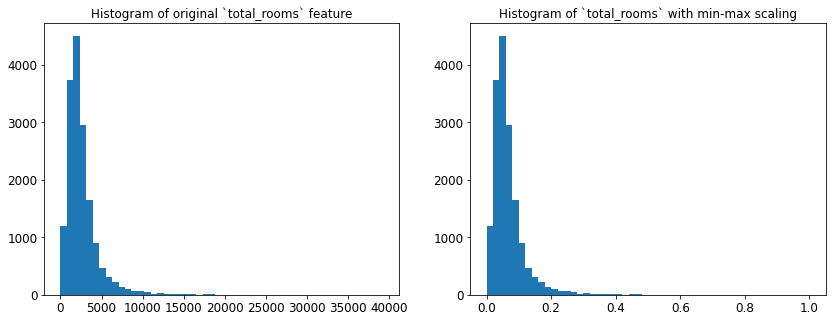

In [41]:
#@markdown Plot two histograms to compare the effect of min-max scaling
plt.figure(figsize=(14,5)) 

# original unscaled data
plt.subplot(1,2,1)
plt.hist(train_copy["total_rooms"], bins=50)
plt.title( "Histogram of original `total_rooms` feature")

# min-max scaling / normalization
plt.subplot(1,2,2) 
plt.hist(total_rooms_mm_scaled, bins=50)   # histogram with 50 bins
plt.title( "Histogram of `total_rooms` with min-max scaling")
plt.show()

### Option 2: Standardization

In [42]:
#@markdown Perform standardization on the `total_rooms` feature 
feature_mean = train_copy["total_rooms"].mean()
feature_stdev = train_copy["total_rooms"].std()
total_rooms_standardized = (train_copy["total_rooms"]-feature_mean)/feature_stdev

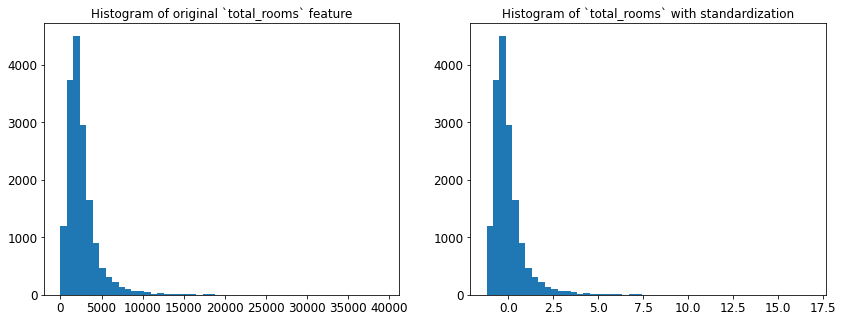

In [43]:
#@markdown Plot two histograms to compare the effect of standarization
plt.figure(figsize=(14,5)) 

# original unscaled data
plt.subplot(1,2,1)
plt.hist(train_copy["total_rooms"], bins=50)
plt.title( "Histogram of original `total_rooms` feature")

# min-max scaling / normalization
plt.subplot(1,2,2) 
plt.hist(total_rooms_standardized, bins=50)   # histogram with 50 bins
plt.title( "Histogram of `total_rooms` with standardization")
plt.show()

## **All steps** applied in our dataset

*Expand to see the steps we follow for our dataset.*

We implement the following choices for our dataset:

In [44]:
#@title 1. **Data cleaning**

#@markdown We replace all missing values of `total_bedroom` with the **median value** calculated in the <font color=red>**training set**</font>.
median_val = train_set["total_bedrooms"].median()             # calculate median from the training set
train_set["total_bedrooms"].fillna(median_val, inplace=True)  # replace all missing values in training set
test_set["total_bedrooms"].fillna(median_val, inplace=True)    # ... and test set

# make a copy of the training and testing here, before defining the categorical features
train_copy = train_set.copy()
test_copy = test_set.copy()

In [45]:
#@title 2. **Handling Text and Categorical Features**

#@markdown We transform the categorical feature `ocean_proximity` into binary indicators for each value ("dummy variables")

# add dummy variables for "ocean_proximity" to both training and test sets 
train_set = train_set.join(pd.get_dummies(train_set["ocean_proximity"]))
test_set = test_set.join(pd.get_dummies(test_set["ocean_proximity"]))

# remove the original categorical 'ocean_proximity' feature, as it's no longer needed
train_set = train_set.drop(columns=["ocean_proximity"])
test_set = test_set.drop(columns=["ocean_proximity"])

In [46]:
#@title 3. **Feature scaling**

#@markdown We do **not** re-scale any features since we will be using ML methods that are not sensitive to scaling.


In [47]:
#@markdown Let's separate the predicted variable from the rest of the features
X_train = train_set.drop("median_house_value", axis=1)  # drop the target for the training set    
y_train = train_set["median_house_value"]

X_test = test_set.drop("median_house_value", axis=1)  # drop the target for the test set 
y_test = test_set["median_house_value"]

In [48]:
#@markdown We remove the **`INLAND`** dummy variable to avoid multicollinearity
X_train.drop("INLAND", axis=1, inplace=True)
X_test.drop("INLAND", axis=1, inplace=True)

# <font color = red>**TASK #4.**


# **7. Train the Machine Learning Model**
The next step is to train machine learning models using the training data. 
We will train (and subsequently test) three different ML models: a **linear model**, a **decision tree**, and a **random forest**.

_**Run this entire section.** We will be replicating some parts of the analysis in Excel, so we suggest expanding the hidden cells and then choosing which sub-section to expand further._


## Our Three ML Models in a Nutshell 
_If you have never seen some of these models, you may want to uncomment this and read for a very quick description._

The three models that we are training can be quickly summarized as follows:
* In a **linear model**, the predicted value of the target is given by a linear function of the predictors $X_1,\dots,X_m$. That is:
> $\beta_0 + \beta_1 \cdot X_1 + \dots + \beta_m \cdot X_m,$

 where $\beta_0$ is a constant term (intercept), and $\beta_1,\dots,\beta_m$ are the coefficients that determine the dependency.

* In a **Decision Tree** (or more precisely, a **Regression Tree** in our case), the predicted value is given by the **average** of the target values for all the samples that satisfy a nested sequence of **IF/THEN** statements. These nested **IF/THEN** statements can be visualized on a tree, which gives the method its name. If you have never seen this before, it will become very clear once we actually visualize a tree. (For details, you can check out [this](https://www.youtube.com/watch?v=g9c66TUylZ4) video tutorial).

* A **Random Forest** is just an ensemble of many decision trees. The predicted value is given by the **average** of the predictions of all trees. Random Forests were invented by Leo Breiman, and are based on a few smart tweaks that are aimed to make the trees in the ensemble "work well" together. (For details, check out [this](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&ab_channel=StatQuestwithJoshStarmer) video tutorial.)

## **Train** or **Fit** the Models
This is the critical step where each ML model is **fitted** (or **trained**) using the data in our **training set**. 

_**Run the entire section.** We recommend expanding this and reading the sub-section that describes **what** this process actually means, with examples focused on the three ML models we are considering._

### What Does it Mean to **Fit** (or **Train** or **Estimate**) an ML Model? 
*Expand and read this if you would like to understand more about what actually happens when we train an ML algorithm.*

To make the notions precise, it is helpful to define a tiny bit of **notation**.  
> Suppose we denote the value of the **target** with $y$, and the value of the **predictors** with $X_1, X_2,\dots,X_m$. For instance, in our case, $y$ would be the `median_house_value`, and $X_1$ is the value of `longitude`, $X_2$ is the value of `latitude`, etc. Since these take different values in each of the samples in our data, we would like to have a way to refer to the values in each sample. So if we use an index $i$ to refer to the $i$-th sample, we will denote by $y^{(i)}$ the value of the target in the $i$-th sample, and with $X_1^{(i)}, X_2^{(i)},\dots,X_m^{(i)}$ the values of the predictors in the $i$-th sample. Lastly, let's assume that the **training set** consists of the $N$ samples indexed $1,2,\dots,N$.

**What <font color=red>is</font> a predictive ML model, and what does it actually <font color=red>do</font> when predicting?<br>**
> Each of the ML models we work with has a set of internal **parameters** $\beta$ that characterize it, and a certain **functional way** $F(\cdot)$ of predicting the values of the target given values of the predictors and parameters. Here, $F(\cdot)$ is really just a function that is specific to the kind of ML model we use, and that determines **how predictions are done**: given the internal parameters $\beta$ and predictors with values $X_1, X_2, \dots, X_m$, our ML model would **predict a value** $\hat{y} = F(\beta, X_1, X_2,\dots,X_m)$ for the target.

**Some Specific Examples.**
* In a **linear model**, the predicted value of the target $\hat{y}$ is given by a linear function of the predictors $X_1,\dots,X_m$:
> $ \hat{y} = \beta_0 + \beta_1 \cdot X_1 + \dots + \beta_m \cdot X_m.$

 So here, the **internal parameters** are the intercept $\beta_0$ and the coefficients $\beta_1,\dots,\beta_m$, and the function $F(\cdot)$ is the linear mapping above.

* In a **decision tree**, the predicted value $\hat{y}$ is given by a nested sequence of **IF/THEN** statements on the predictors, of the form:
> $ \hat{y} = \texttt{IF}( X_{p_1} \leq \beta_{p_1}, \texttt{IF} (X_{p_2} \leq \beta_{p_2}, (\dots), ) \dots ).$

 Here, $X_{p_1}, X_{p_2}$, etc. denote the predictor used in each node of the tree (chosen from the predictors $X_1,\dots,X_m$, with the same predictor possibly occuring several times), and the coefficients $\beta_{p_1}, \beta_{p_2}$, etc. determine the splits in each node of the tree. The **internal parameters** are the choice of predictor to use at each node of the tree ($p_1,p_2$, etc.) and the corresponding values $\beta_{p_1}, \beta_{p_2}$. (In addition to these, there are also several so-called "hyper-parameters" that control other aspects of the tree, such as how deep the tree can become.) The function $F(\cdot)$ is given by the nested sequence of **IF/THEN** statements.

* A **random forest** is simply a collection/ensemble of several trees, so the **internal parameters** correspond to all the internal parameters we described above for each tree. (In addition, there are also hyper-parameters that determine, e.g., how many trees to use.) The function $F(\cdot)$ for a random forest is given by the average of the functions $F(\cdot)$ for the trees in the forest.

**What does it mean to <font color=red>train</font> a predictive ML algorithm?**<br>
> When we **estimate** (or **fit** or **train**) an ML model, we are effectively trying to find values for the internal parameters $\beta$ of the model so that the predictions are "as accurate as possible" in the training set. More formally, we are solving an **optimization problem** that seeks values for the parameters $\beta$ that would **minimize the prediction error calculated in the training set**.

**What <font color=red>is</font> the prediction error and how do we <font color=red>measure</font> it?**<br>
> There are several ways to quantify/measure the prediction error in regression tasks. By far the most popular way is to use the **mean squared error**, but it is also possible to use **mean absolute error** or even some other custom error metric. <br>
 To understand these, let us denote with $\hat{y}^{(i)} = F(\beta,X_1^{(i)}, X_2^{(i)},\dots,X_m^{(i)})$ the prediction that our algorithm would make for each sample $i$ in our training set. Then, the two ways to measure error above are:
 * the **mean squared error**: $\frac{1}{N}\sum_{i=1}^N (y^{(i)} - \hat{y}^{(i)})^2 $
 * the **mean absolute error**: $\frac{1}{N}\sum_{i=1}^N |y^{(i)} - \hat{y}^{(i)}| $.

### Model #1: A **Linear Regression**

<font color=green>**EXCEL:** As you already know, this can be done in Excel using the `LINEST()` function or the **Regression** function under **Data > Data Analysis**.</font>

Recall that in a **linear model**, the predicted value of the target $\hat{y}$ is given by a linear function of the predictors $X_1,\dots,X_m$, that is:
> $ \hat{y} = \beta_0 + \beta_1 \cdot X_1 + \dots + \beta_m \cdot X_m,$

where $\beta_0$ is an intercept, and $\beta_1,\dots,\beta_m$ are the coefficients that determine the dependency. 

In [49]:
#@title Train a **Linear** Model
from sklearn import linear_model

# fit the model
linear_model = linear_model.LinearRegression().fit(X_train,y_train)

#@markdown Visualize the results of the training by displaying the coefficients
print("{:25s}: {:,.2f}".format("Intercept:",linear_model.intercept_))
for k in range(len(X_train.columns)):
  print("{:25s}: {:,.2f}".format(X_train.columns[k],linear_model.coef_[k]))

Intercept:               : -2,223,924.17
longitude                : -25,917.09
latitude                 : -24,814.49
housing_median_age       : 1,012.97
total_rooms              : -4.93
total_bedrooms           : 69.62
population               : -37.83
households               : 77.24
median_income            : 38,849.58
<1H OCEAN                : 40,059.45
ISLAND                   : 256,791.70
NEAR BAY                 : 37,933.28
NEAR OCEAN               : 44,539.32


### Model #2: A **Decision Tree**

<font color=green>**EXCEL:** Unfortunately there is no built-in function for this in Excel (yet), but many add-ins are available, e.g., [Analytic Solver](https://www.solver.com/xlminer-data-mining).</font>

With more complex ML models, there are always a few **"hyper-parameters"** we can set when constructing the model. These typically control how complex the model is allowed to become, with more complex models fitting the data better, but requiring more computational time.

For instance, when creating a regression tree we can specify a **maximum depth** that controls how many layers the tree can have. Larger trees fit the training data better, but take longer time to fit and are harder to visualize. (There are several other "hyper-parameters" that can be set as well, but we will not discuss them for simplicity; see [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) for more details).

In [50]:
#@title Train a **Decision Tree**
from sklearn.tree import DecisionTreeRegressor

#@markdown Select or type the **maximum depth** depth your tree is allowed to have (selecting **`None`** will allow any depth):
max_depth = "3" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}

if max_depth == "None":
  max_depth = None
else:
  max_depth = np.int(max_depth)

tree_model = DecisionTreeRegressor(criterion='mse', max_depth=max_depth, \
                                   random_state=123)
aux = tree_model.fit(X_train, y_train)

print("Success!")

Success!


As the name suggests, these models can be conveniently visualized on a tree. 

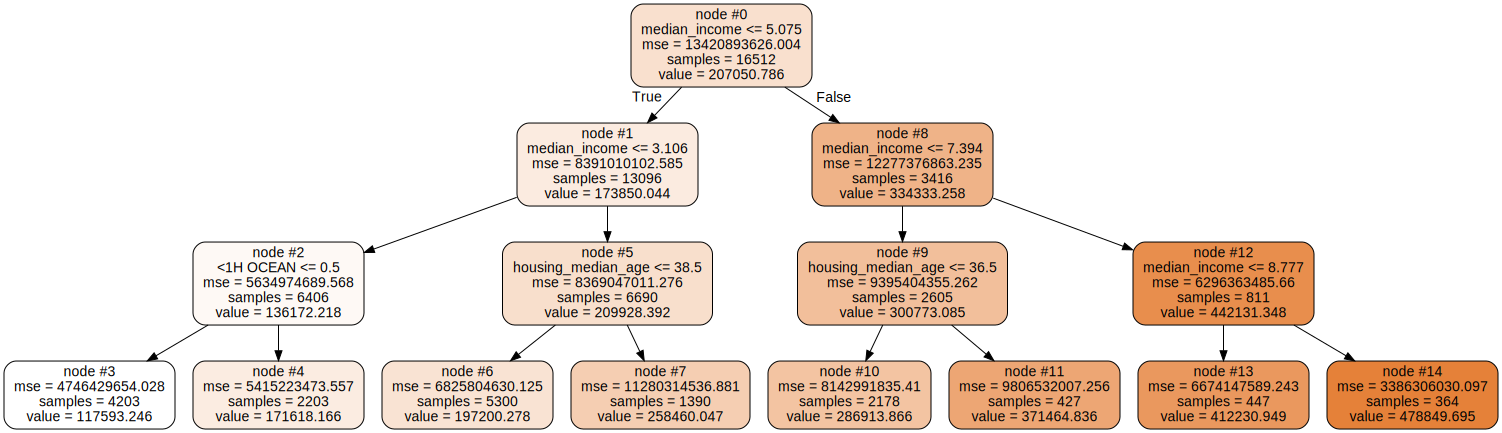

In [51]:
#@title **Visualize** the fitted tree
from sklearn import tree

#@markdown You can adjust how many levels to display with a **maximum depth**. A large depth may generate a picture that is harder to see. 

#@markdown Select or type the depth you want to visualize (selecting **`None`** will try printing the full tree):
max_depth_to_see = "4" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}

#@markdown The **LEFT** branch corresponds to the **IF** condition being **TRUE**, and the **RIGHT** branch corresponds to it being **FALSE**.

if max_depth_to_see == "None":
  max_depth_to_see = None
else:
  max_depth_to_see = np.int(max_depth_to_see)

dot_data = tree.export_graphviz(tree_model, max_depth=max_depth_to_see, \
                                feature_names=X_train.columns, class_names=None,
                                label='all', filled=True, impurity=True, node_ids=True, \
                                rounded=True, rotate=False, proportion=False)
graph = graphviz.Source(dot_data)  
graph

When interpreting the tree above, the main thing to note is the logical condition in each node. This is the **split condition**, and it always involves one of the features in our model. The two subtrees correspond to the two possible outcomes: **the left subtree for the condition being true**, and the **right subtree for the condition being false**. The **color** of each node is indicative of the average value of all the samples that fall in that node: the darker the color is, the higher the value.

When the tree is **trained/fitted**, the ML algorithm determines **which feature to use at each node** and **what threshold to use for the split**, and its goal in doing this is to reduce the prediction error in the entire training set.

**Predictions** for a new sample are done by following all the conditions based on the predictors until a final leaf is reached, and taking the **average** of the target variable for all the training samples in that leaf node.

### Model #3: A **Random Forest**

<font color=green>**EXCEL:** Unfortunately there is no built-in function for this in Excel (yet), but many add-ins are available, e.g., [Analytic Solver](https://www.solver.com/xlminer-data-mining).</font>

Just as in the case of the decision tree, there are several "hyper-parameters" we can specify when training a random forest. For instance, an important one is the **number of trees** (or estimators) in the forest ensemble, and we can also give a **maximum depth** for each of the trees. Forests with more or deeper trees will fit data better, but also require more time to train. 

In [52]:
#@title Train a **Random Forest** with 50 Trees
from sklearn.ensemble import RandomForestRegressor 

#@markdown Select the number of trees (estimators) to use:
n_estimators = "50" #@param [5, 10, 20, 30, 40, 50] {allow-input: true}
n_estimators = np.int(n_estimators)

#@markdown Select or type the depth you want to use (selecting **`None`** will allow any depth):
max_depth = "5" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}

if max_depth == "None":
  max_depth = None
else:
  max_depth = np.int(max_depth)

rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                 random_state=42, oob_score=True)
aux = rf_model.fit(X_train, y_train)

print("Success!")

Success!


Since a random forest consists of many trees, it becomes significantly harder to visualize what the overall trained model looks like. One thing we could do is to plot a few of the trees in the ensemble, but these can actually look very different from each other! Random forests are actually an example of a **black-box** model, and as you can already see, it can be **hard to visualize** such models and **very hard to interpret** concisely how they arrive at their predictions **or to understand the impact of a feature** on the predicted values. We will devote the last section of our tutorial to discussing a set of practical tools that can help de-mistify the workings of such models. 

# <font color = red>**TASK #5**</font>
<font color=red>**A.** Use the trained **linear regression model** from Excel or from Colab to answer these questions. If you are very comfortable with linear regression, feel free to skip directly to part B.</font>
1. What is the impact of `housing_median_age` and `median_income` on the predicted median house values in a district?
2. What is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$ for your model?
3. Are the coefficients in your model statistically significant? <font color=purple>(**Hint.** Look at the **P-value** column: if the value reported there is very small, it is an indication the coefficient is **significant**. More precisely, the likelihood that the coefficient is **zero** is at most **P-value**).</font> 
4. Predict the median house value for the first 5 samples in the test set, and calculate the **relative errors** in the prediction.

<font color=red>**B.** Use the **Colab notebook** to address the following issues:</font>
1. **For your trained Decision Tree model:** 
 - Can you interpret how the model would predict for a new sample?
 - By visualizing the model, what features seem "most important" for predicting?  
 - What is the root mean-squared error (RMSE) when predicting in the training set?   
 - What is the mean-squared error (RMSE) when predicting in the test set?   

2. **What is the impact of the `max_depth` parameter used when training the tree?** <br>
Specifically, train a decision tree model where `max_depth=None`, and consider the following questions:
 - How do the errors/predictive accuracy change in the training and test set? <font color=purple>(**Hint:** Look at the *“Model Complexity and Overfitting”* section in the Colab notebook!)</font>  
 - What happens to the interpretability of the model?  
 - Is it "best" to select a very large depth for the tree?  

3. **Consider the Random Forest model.**  
  * According to the **permutation feature importance**, which features are most relevant for predicting the median house value? 
  * Based on the **partial dependency plot**, does a larger `housing_median_age` lead to a lower or higher median house value?  
  * Do you find any evidence of "bias" in how the algorithm is predicting in different geographic locations?  

# **8. Evaluate and Interpret the Model**
The next step is perhaps one of the most important ones: actually evaluating and understanding our ML model. There are many important issues to bear in mind when it comes to this, and an exhaustive discussion would be difficult. But any responsible implementation should consider the following questions:

1. **How accurate is the model?**  _(How well can it fit the data in the **training set** and, more importantly, predict in the **test set**?)_

2. **Is the model exhibiting any bias?** _(Does the quality of the prediction change with certain features or categories?)_

3. **Can we interpret/explain the model?**  _(Can we **concisely** explain **how** it reaches its predictions and quantify the **impact** of features?)_

This section tries to provide some processes and tools to answer such questions.

_**Run this entire section.** We will be replicating some parts of the analysis in Excel, so we suggest expanding the hidden cells and then choosing which sub-section to expand further._

## Evaluating the **Predictive Accuracy**

The first step is to evaluate the ML model at the task it is actually supposed to achieve, i.e., **prediction**. Specific things to look at are:
* How well is the model predicting in the **training set**? _(Is it good at fitting the data it was trained on...)_  
* Is the model predicting "well" under other performance metrics? _(We may want to calculate a few different metrics of accuracy.)_  
* How well is the model predicting in the **test set**? _(The most critical test of all, as this is **new** data that the algorithm hasn't seen before.)_

In [53]:
#@markdown Define a function to calculate and display useful performance metrics
def calculate_performance_metrics(label_dataset, y_true, y_pred, display=False):

    mse = metrics.mean_squared_error(y_true, y_pred) 
    rmse = np.sqrt(mse) 
    r2 = metrics.r2_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)

    if display:
      print("Results in the {} Set:".format(label_dataset))
      print('MSE:       ', round(mse,4))
      print('RMSE:      ', round(rmse,4))
      print('R-squared: ', round(r2,4))
      print('MAE:       ', round(mae,4))
    
    return mse, rmse, r2, mae

### Predictions in the **Training Set**
The first thing is to see how well our ML models are able to fit the data that was used to train them.

In [54]:
#@title Predict with each method for all the samples

# predict with each method
yhat_linear_train = linear_model.predict(X_train)
yhat_tree_train = tree_model.predict(X_train)
yhat_rf_train = rf_model.predict(X_train)

# join all results into a single dataframe, including the training data, predictions and errors
results_train = pd.concat([train_copy, \
                           pd.DataFrame( {'linear_prediction' : yhat_linear_train, \
                                          'tree_prediction' : yhat_tree_train, \
                                          'rf_prediction' : yhat_rf_train, \
                                          'linear_error(%)' : 100*(1.0-yhat_linear_train/y_train), \
                                          'tree_error(%)' : 100*(1.0-yhat_tree_train/y_train), \
                                          'rf_error(%)' : 100*(1.0-yhat_rf_train/y_train)}, \
                                        index = X_train.index ) ], axis=1)

In [55]:
#@title Display a few samples to compare the methods

#@markdown Select or type how many samples to display:
num_samp = "9" #@param [5, 10, 20] {allow-input:true}

results_train.head(np.int(num_samp))

longitude  latitude  ...  tree_error(%)  rf_error(%)
Index                       ...                            
2527     -122.20     39.53  ...         -65.62       -30.16
12116    -117.23     33.96  ...         -75.70       -39.51
12443    -115.22     33.54  ...        -119.80       -72.74
8494     -118.30     33.90  ...          -8.71       -23.10
5455     -118.46     34.01  ...          13.03        11.45
7349     -118.16     33.97  ...           9.96        24.47
3850     -118.46     34.18  ...          22.12         3.70
9935     -122.30     38.27  ...         -51.46       -18.95
17400    -120.44     34.93  ...         -96.14       -84.96

[9 rows x 16 columns]

Next, we can evaluate and display a few different performance metrics in the **entire training set**.

In [56]:
#@title Calculate and display the performance in the entire **training set**

#@markdown Let's calculate and display the mean squared error (**MSE**), root mean squared error (**RMSE**), R-squared (**R2**), and mean absolute error (**MAE**).

pf_index = ["MSE", "RMSE", "R2", "MAE"]
linear_metrics = calculate_performance_metrics("Training", y_train, yhat_linear_train, display=False)
tree_metrics = calculate_performance_metrics("Training", y_train, yhat_tree_train, display=False)
rf_metrics = calculate_performance_metrics("Training", y_train, yhat_rf_train, display=False)

# join all dataframes into one
summary_train_metrics = pd.DataFrame({"linear_model" : linear_metrics, \
                                      "tree_model" : tree_metrics, \
                                      "rf_model" : rf_metrics}, index=pf_index )

# display all performance metrics 
summary_train_metrics.head()

linear_model       tree_model         rf_model
MSE  4,794,030,264.29 6,654,201,044.45 4,667,182,744.00
RMSE        69,238.94        81,573.29        68,316.78
R2               0.64             0.50             0.65
MAE         50,080.61        60,371.79        49,160.64

### Predictions in the **Test Set**
A critical step in the evaluation process is to assess performance in the **test set**, which contains data that is new to our ML algorithms.

We can apply the same steps that we took earlier for the training set.

In [57]:
#@title Predict with each method for all the samples

# predict with each method and save the results as a dataframe
# predict with each method
yhat_linear_test = linear_model.predict(X_test)
yhat_tree_test = tree_model.predict(X_test)
yhat_rf_test = rf_model.predict(X_test)

# join all results into a single dataframe, including the training data, predictions and errors
results_test = pd.concat([test_copy, \
                          pd.DataFrame( {'linear_prediction' : yhat_linear_test, \
                                         'tree_prediction' : yhat_tree_test, \
                                         'rf_prediction' : yhat_rf_test, \
                                         'linear_error(%)' : 100*(1.0-yhat_linear_test/y_test), \
                                         'tree_error(%)' : 100*(1.0-yhat_tree_test/y_test), \
                                         'rf_error(%)' : 100*(1.0-yhat_rf_test/y_test)}, \
                                       index = X_test.index ) ], axis=1)

In [58]:
#@title Display a few samples to compare the methods

#@markdown Select or type how many samples to display:
num_samp = "8" #@param [5, 10, 20] {allow-input:true}

results_test.head(np.int(num_samp))

longitude  latitude  ...  tree_error(%)  rf_error(%)
Index                       ...                            
16066    -122.48     37.75  ...          17.87        -2.01
20581    -122.21     38.83  ...         -59.81       -18.54
11174    -117.97     33.82  ...          16.37        28.32
11302    -117.92     33.78  ...          -5.74        -9.51
7114     -118.02     33.92  ...           9.83         7.15
7885     -118.14     33.87  ...          -0.13         2.03
17289    -119.63     34.42  ...          17.55         7.35
13008    -121.29     38.68  ...          18.34        35.82

[8 rows x 16 columns]

And we can re-calculate all the performance metrics in the **entire test set**.

In [59]:
#@title Calculate and display the performance in the entire **test set**

#@markdown We calculate and display the mean squared error (**MSE**), root mean squared error (**RMSE**), R-squared (**R2**), and mean absolute error (**MAE**).

pf_index = ["MSE", "RMSE", "R2", "MAE"]
linear_metrics = pd.DataFrame(calculate_performance_metrics("Test", y_test, yhat_linear_test, display=False), \
                              index=pf_index, columns=['linear_model'])
tree_metrics = pd.DataFrame(calculate_performance_metrics("Test", y_test, yhat_tree_test, display=False), \
                            index=pf_index, columns=['tree_model'])
rf_metrics = pd.DataFrame(calculate_performance_metrics("Test", y_test, yhat_rf_test, display=False), \
                          index=pf_index, columns=['rf_model'])

# join all dataframes into one
summary_test_metrics = pd.concat([linear_metrics, tree_metrics, rf_metrics], axis=1)

# display all performance metrics 
summary_test_metrics.head()

linear_model       tree_model         rf_model
MSE  4,438,524,510.53 6,731,927,545.06 4,704,224,790.47
RMSE        66,622.25        82,048.32        68,587.35
R2               0.66             0.48             0.64
MAE         48,816.45        60,865.72        49,629.64

It is important to **compare** the performance in the **training** and the **test** data. If you are seeing a big degradation in the performance on the test set compared to the training set, it is likely because the model is **overfitting** the training data. Loosely speaking, overfitting occurs when the model has a lot of degrees of freedom and it uses these to perfectly match the training set. But this also means the model ends up fitting a lot of the noise in the training data, so it fails to perform well on new data (such as in the test set). 

### Model Complexity and Overfitting
To help you understand overfitting, we will try a small exercise below: we will systematically change the `max_depth` parameter that controls how deep our decision tree model can grow, train a tree for each depth level, and record its predictive accuracy in both the training and the test set.

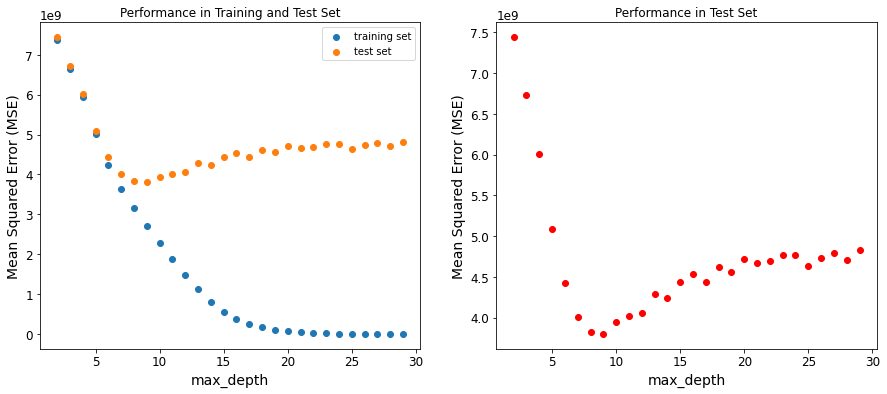

In [60]:
#@title Train trees with depth values from 2 to 30 and plot their performance
max_depth_values = np.arange(2,30,1)
training_performance = np.zeros(len(max_depth_values))
test_performance = np.zeros(len(max_depth_values))

for i in range(len(max_depth_values)):
    # train a new decision tree model with max_depth = i
    new_tree_model = DecisionTreeRegressor(criterion='mse', max_depth=max_depth_values[i], random_state=123)
    new_tree_model.fit(X_train, y_train)
    
    # record the MSE in training and test set
    training_performance[i] = metrics.mean_squared_error(y_train, new_tree_model.predict(X_train))
    test_performance[i] = metrics.mean_squared_error(y_test, new_tree_model.predict(X_test))

# plot the performance as a function of max_depth
fig = plt.figure(figsize=(15,6))  # create a figure of the desired size

plt.subplot(1,2,1)
plt.scatter(x=max_depth_values, y=training_performance, label="training set")   # a simple scatter plot
plt.scatter(x=max_depth_values, y=test_performance, label="test set")   # a simple scatter plot
plt.xlabel("max_depth")
plt.ylabel("Mean Squared Error (MSE)")
plt.title( "Performance in Training and Test Set")
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("max_depth")
plt.title( "Performance in Test Set")
plt.scatter(x=max_depth_values, y=test_performance, label="test set", color='red')         # a simple scatter plot
plt.show()

The plots above show a clear trade-off between the maximum tree depth and the performance: as we increase the depth, the algorithm performs better and better in the training set, until it eventually fits the data **perfectly** (at depths above 25 or so). In the test  however, there is initial improvement, but the errors then increase and eventually stabilize. What we are seeing is overfitting in action: as the tree becomes more complex, it fits the training data perfectly, but it stops being able to generalize. If we want our tree to work well on new data, we should pick a tree depth somewhere between 8 and 10. If you are wondering how one could proceed about finding this value in a systematic way, see our final section on **Limitations and Topics Left Out**.

## Evaluating **Bias**
The next step is to understand whether the model is able to predict "uniformly well" across the dataset. Specifically, does the quality of the prediction depend on certain feature values? Does our model exhibiting any bias in the way it predicts for different categories?

A good starting point is to plot the prediction errors as a function of the features. This step is important, as it allows you to **inspect if the errors have a certain pattern**. Specifically, the main thing to look for is whether the magnitude of the prediction errors depends on the value of specific features. If that is indeed the case, it is evidence that your model may not be entirely adequate, and you may want to revisit the way the features are defined (for instance, you may want to define some new features). 

In [61]:
#@title Define a few useful functions to examine the prediction errors

#@markdown A function to see how errors depend on one feature at a time
def visualize_errors(model_name, all_data, target_name, errors, features, \
                     figsize=(10,9)):

    # calculate how many figures are needed
    num_figs = len(features)
    num_columns = (1 if num_figs==1 else 3)
    num_rows = int(np.ceil(num_figs/num_columns))
    
    # one large figure with a common title
    fig = plt.figure(figsize=(figsize[0]*num_columns,figsize[1]*num_rows))
    
    # title for plot
    tar_ylabel = 'Errors in predictions for {}'.format(target_name)

    # calculate the min/max errors
    ymin = np.min(errors)
    ymax = np.max(errors)

    for i in range(num_figs):

      if( (all_data[features[i]].dtype == 'float') or (all_data[features[i]].dtype == 'int') ):
        # numeric feature 

        # Get min & max values
        xmin = all_data[features[i]].min()
        xmax = all_data[features[i]].min()
        
        # Create figure
        plt.subplot(num_rows,num_columns,i+1)
        ax1 = plt.gca()
        #fig, ax1 = plt.subplots(figsize=figsize)
        ax1.grid(alpha=.5, linewidth=1)
        
        # Scatter plot
        color1 = 'tab:blue'
        ax1.scatter(all_data[features[i]], errors, color=color1, alpha=0.2)
        ax1.tick_params(axis='y', labelcolor='black')

      else:
        # categorical feature
        plt.subplot(num_rows,num_columns,i+1)
        ax1 = sns.boxenplot( data=all_data, x=features[i], y=errors, palette="Blues")

      ax1.set_xlabel(features[i], fontsize=12)
      ax1.set_ylabel(tar_ylabel, color='black', fontsize=12)
      ytickvals = ax1.get_yticks()
      ax1.set_yticklabels(["{:.0f}%".format(v) for v in ytickvals], fontsize=12)

    plt.tight_layout()
    # determine the title
    #tar_ylabel = '{}'.format(target_name) if target_name else 'target'
    #fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

    plt.show()


#@markdown A function to see how errors depend on two features (color+size)
def visualize_errors_two_features(all_data, feature_x, feature_y, errors,\
                                  model_name="Model", dataset_name="Data", figsize=(10,8)):

    plt.figure(figsize=(figsize[0],figsize[1]))

    vmax = errors.max()
    vmin = errors.min()
    maxlog = int(np.ceil(np.log10(vmax))) 
    minlog = int(np.ceil(np.log10(-vmin))) 

    # parameters for the logarithmic plot
    logthresh = 0
    logstep = 1
    linscale = 1

    # use matplotlib's symmetric normalizer
    norm = mpl.colors.SymLogNorm(linthresh=10**(-logthresh), linscale = linscale, \
                            vmin=vmin, vmax=vmax)

    if feature_y!= None:
        # two features
        ax = plt.scatter(data=all_data, x=feature_x, y=feature_y, \
                        c=errors, cmap='RdBu_r', norm=norm, alpha=0.3)
    else:
        # just feature_x
        ax = plt.scatter(x=all_data[feature_x], y=errors, \
                        c=errors, cmap='RdBu_r', norm=norm, alpha=0.3)
        

    # generate logarithmic ticks 
    tick_locations =([-(10**x) for x in range(-logthresh, 
                                              minlog + 1, 
                                              logstep)][::-1] 
                    +[0.0] 
                    +[(10**x) for x in range(logthresh, 
                                              maxlog + 1, 
                                              logstep)] )

    cb = plt.colorbar(ticks = tick_locations, format = mpl.ticker.LogFormatter()) 
    log_ticks = cb.get_ticks()
    cb.ax.set_yticklabels(["{:,.0f}%".format(v) for v in log_ticks], fontsize=14)
    cb.set_label("Errors on logarithmic scale", fontsize=14)

    plt.ylabel(feature_y if feature_y!=None else "Errors", fontsize=14)
    plt.xlabel(feature_x, fontsize=14)
    plt.title("Errors for {} in {} Set".format(model_name,dataset_name))
    plt.tight_layout()
    plt.show()

Your selection:
Model:        Random Forest
Dataset:      Training
Feature_x:    median_income
Feature_y:    None
Truncating at: 200.0%


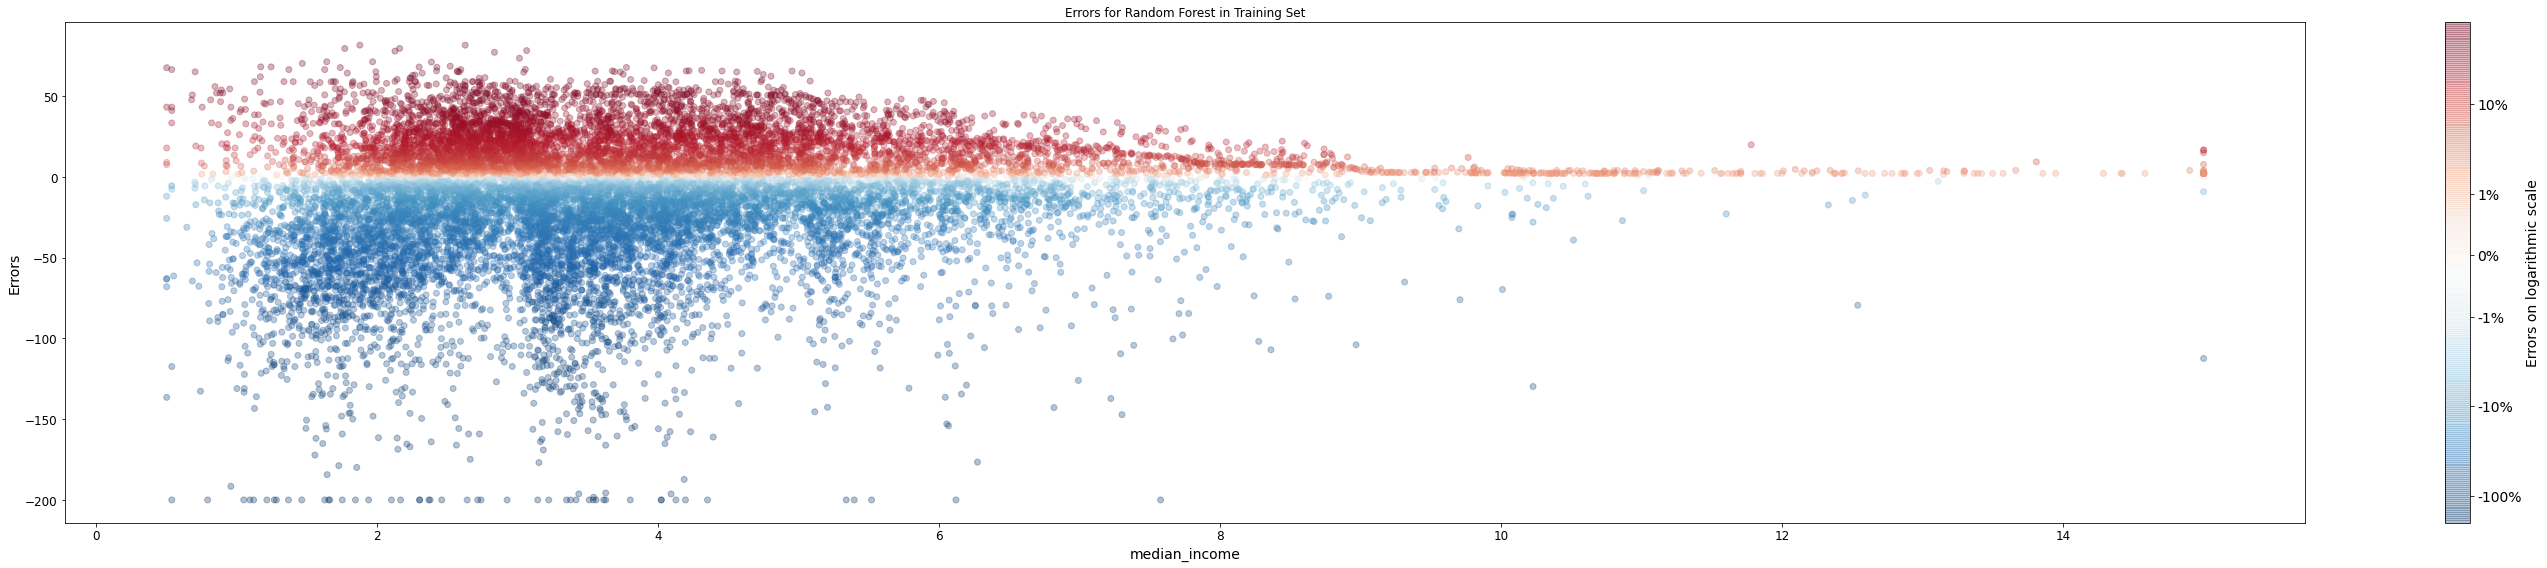

In [62]:
#@title **Visualize how errors depend on two features at a time**

#@markdown Select **one of the models** we trained:
model = "Random Forest" #@param ["Linear Model", "Decision Tree", "Random Forest"]

#@markdown Select at most two **features** from the dropdown menus to visualize errors

feature_x = 'median_income' #@param ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
feature_y = 'None' #@param ["None", "longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

if feature_y == "None":
  feature_y=None

#@markdown Select **which dataset** to do the plot for:
dataset = "Training" #@param ['Training', 'Test']

#@markdown <br>**Select the type of plot to see**<br>
#@markdown (In the scatter plot, the **colors** capture the direction of errors: <font color=red>**red**</font> for large **positive** errors, and <font color=blue>**blue**</font> for large **negative** errors.)
#@markdown - **scatter** is the usual scatter plot you are familiar with
#@markdown - **average_dependency** displays the average value of the errors
plot_type = 'scatter' #@param ['average_dependency', 'scatter']

#@markdown <br>**Customize some aspects of the plot**<br>
#@markdown (**`num_bins`** : the number of bins to use for the average dependency plot; leave as **Auto** if unsure)
figure_width = '40' #@param ['Auto']{allow-input : true}
figure_height = '8' #@param ['Auto']{allow-input : true}
num_bins = '30' #@param ['Auto']{allow-input : true}

#@markdown You can use **`max_abs_error`** to truncate errors above a certain threshold.<br>(This may be useful if some errors are extremely large. 
#@markdown Select a value (in %) where to truncate; leave as **None** if you do not want to truncate.)
max_abs_error = "200" #@param ['100', '200', '500', '1000', 'None'] {allow-input:true}

if figure_width=="Auto":
  figure_width=5.0
else:
  figure_width=np.float(figure_width)

if figure_height=="Auto":
  figure_height=5.0
else:
  figure_height=np.float(figure_height)

if num_bins=='Auto':
  num_bins=10
else:
  num_bins=np.int(num_bins)

# select the right dataset
if dataset=="Training":
  results = results_train  # pass the original dataframes to be able to plot categorical features
else :
  results = results_test  # pass the original dataframes to be able to plot categorical features

# select the right errors corresponding to the model
if model == "Linear Model":
  errors = results["linear_error(%)"]
elif model == "Decision Tree":
  errors = results["tree_error(%)"]
else:
  errors = results["rf_error(%)"]

# select the right dataset
if dataset=="Training":
  X_data = X_train
  y_data = y_train
  results = results_train
else :
  X_data = X_test
  y_data = y_test
  results = results_test

# print the selections
print("Your selection:")
print("Model:        {}".format(model))
print("Dataset:      {}".format(dataset))
print("Feature_x:    {}".format(feature_x))
print("Feature_y:    {}".format(feature_y))

# truncate errors if wanted
if( max_abs_error != "None"):
  max_abs_error = np.float(max_abs_error)
  errors = errors.copy()
  errors[errors>max_abs_error] = max_abs_error
  errors[errors<-max_abs_error] = -max_abs_error
  print("Truncating at: {}%".format(max_abs_error))

if plot_type=='average_dependency':
    # append dummies and store categories for plotting average dependency
    modif_X_data = train_copy.merge( errors, left_index=True, right_index=True)
    data_with_dummies, data_categories = append_dummies(modif_X_data, modif_X_data.columns)

    visualize_average_dependency(all_data_with_dummies=data_with_dummies,\
                                 all_categories=data_categories, \
                                 feature_y=errors.name, feature_x1=feature_x,\
                                 feature_x2=feature_y, num_bins=num_bins,\
                                 figsize=(figure_width,figure_height))
else:
    # do the scatter plot
    aux = visualize_errors_two_features(all_data=results, feature_x=feature_x, \
                                  feature_y=feature_y, errors=errors,\
                                  model_name=model, dataset_name=dataset,\
                                  figsize=(figure_width,figure_height))
# uncomment next line to save
#save_fig("scatterplot_of_{}_and_{}".format(feature1,feature2))

This step is important for several reasons:
   - it can allow you to detect if the errors have a certain pattern, which may inform the design of better features to use when training
   - it can enable you to detect iif your ML algorithm exhibits some form of bias, such as predicting better for certain categories than others.
   
Additionally, having such variable predictive accuracy could also be evidence of systematic bias, which can be particularly problematic. such as predicting better for certain categories than others.

We will return to these points in a future class, where we examine issues of bias and fairness in detail.

## **Interpreting** the Model

The final question to address is **can we interpret/explain the model?**  Specifically,
 * Can we **concisely** explain **how** the model reaches its predictions?  
 * Can we quantify how the predictions **change** with the values of the features? 

Addressing these issues is critical if we want our models to be adopted in practice, so we discuss a few processes that can help.

_**Run the entire sub-section** and expand to see specific subsections._


### Direct **Visualization**
If possible, the first step is to **visualize** the ML model, which can also help summarize its inner workings. Our ability to do this is unfortunately limited: **white-box** models like linear models or trees can be visualized, but this is significantly harder for **black-box** models like random forests. 

_We already visualized each model in the training step, so you can skip this section if everything made sense. Expand for a brief discussion._

#### **Linear Models**
Recall that in linear models, the predicted value of the target is a linear function of the predictors $X_1,\dots,X_m$:
> $ \beta_0 + \beta_1 \cdot X_1 + \dots + \beta_m \cdot X_m,$

So all we need in order to understand the model are the parameters $\beta_0, \beta_1,\dots,\beta_m$. This achieves two things at once:
1. it concisely summarizes the **mechanism** by which predictions are made: just apply the linear function to a new sample;
2. it allows quantifying **the impact of each feature** on the prediction: this is given by the corresponding coefficient.

**Caveat.** In practice, even linear models may be hard to interpret, particularly when they rely on **derived features** that depend in a complex way on the initial features. Such derived features are often added during the **feature engineering** step in order to improve the quality of the prediction, so this situation can easily arise in complex prediction problems. 

In [63]:
#@markdown Let's consider our linear model for an example. 

#@markdown First, let's print out the coefficients.
print("intercept: {:<.3f}".format(linear_model.intercept_))
for k in range(len(X_train.columns)):
  print("{}: {:<.3f}".format(X_train.columns[k],linear_model.coef_[k]))

intercept: -2223924.169
longitude: -25917.089
latitude: -24814.491
housing_median_age: 1012.968
total_rooms: -4.926
total_bedrooms: 69.615
population: -37.834
households: 77.241
median_income: 38849.582
<1H OCEAN: 40059.451
ISLAND: 256791.702
NEAR BAY: 37933.282
NEAR OCEAN: 44539.316


Access to the coefficients allows us to quickly summarize the impact of a feature in the original model. For instance, our model predicts that increasing the median house age by 1 (year) would increase the median house value by roughly \$1,013, holding all else equal.

However, this would no longer be the case with derived features. For instance, imagine that in order to improve the accuracy of our predictions, we decided to include among our predictors the squared value of the `total_rooms` feature or the ratio of `total_rooms` to `total_bedrooms`. Even if we had access to the coefficients for all these extra features (after fitting the larger model), we would have a much harder time in **concisely** summarizing the impact of `total_rooms`, as all the extra predictors would involve it.

#### **Decision Trees**
These lessons extend to the case of decision trees:
* a tree with small depth can be easily visualized, and the mechanism by which it achieves its predictions can be summarized concisely through simple **IF**/**THEN** rules and **averaging**
* the impact of a particular feature can be quantified **for small trees** (i.e., with low depth), but becomes harder for larger trees, where the same feature may appear in multiple nodes of the tree
* as trees become more complex (e.g., deeper), our ability to understand their behavior is significantly hampered.



### Calculate the **Permutation Feature Importance**
To quantify how **important** each feature is in predicting the target, it is very useful to calculate the **permutation feature importance**. This can be done for any kind of model, including black-box models.

_We already visualized each model in the training step, so you can skip this section if everything made sense. Expand for a brief discussion._

**Permutation feature importance** is a model inspection technique that can be used for any model trained using tabular data. This is especially useful for non-linear or black-box estimators. The permutation feature importance is defined as the decrease in the $R^2$ model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model's predictive performance depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature. You can read more about the `scikit-learn` implementation of the feature [here](https://scikit-learn.org/stable/modules/permutation_importance.html).

**Caveat.** Features that are deemed of low importance for a **bad** model (i.e., with low cross-validation score) could be very important for a **good** model. Therefore it is always important to evaluate the predictive power of a model using a test set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect the intrinsic predictive value of a feature by itself, but rather how important this feature is for a particular model.

In [64]:
#@title Calculate **Permutation Feature Importance**

#@markdown Select one of the models we trained:
model = "Random Forest" #@param ["Linear Model", "Decision Tree", "Random Forest"]

# select the right model
if model == "Linear Model":
  use_model = linear_model
elif model == "Decision Tree":
  use_model = tree_model
else:
  use_model = rf_model

#@markdown Select which dataset to do the calculation for:
dataset = "Test" #@param ['Training', 'Test']

# select the right dataset
if dataset=="Training":
  X_data = X_train
  y_data = y_train
else :
  X_data = X_test
  y_data = y_test

#@markdown Select how many times to repeat the random shuffling:
n_repeats = 30 #@param [30,50,100]{allow-input: true}
n_repeats = np.int(n_repeats)

from sklearn.inspection import permutation_importance
r = permutation_importance(use_model, X_data, y_data,
                           n_repeats=n_repeats,
                           random_state=0)

# print the features in decreasing order of the mean importance
print("The features and the mean (and standard deviation) of importance")
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X_train.columns[i]:<20}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

The features and the mean (and standard deviation) of importance
median_income       0.865 +/- 0.020
<1H OCEAN           0.130 +/- 0.006
housing_median_age  0.092 +/- 0.006
longitude           0.089 +/- 0.003
NEAR OCEAN          0.057 +/- 0.002
NEAR BAY            0.034 +/- 0.002
latitude            0.027 +/- 0.002
total_bedrooms      0.001 +/- 0.000
total_rooms         0.001 +/- 0.000
households          0.000 +/- 0.000
population          0.000 +/- 0.000
ISLAND              0.000 +/- 0.000


### Plotting **Partial Dependencies**
One of the best ways to understand the workings of complex ML models is through **partial dependence plots**. Let's see these in action.

_**Run the entire sub-section** and expand for and explanation and the visualizations._


In [65]:
#@markdown Define a function to visualize partial dependence plots with histograms of features overlayed
def partial_dependence_plots(dataset, model_name, model, X, features, target_name=False, show_hist=False, \
                             show_density=True, figsize=(10,9)):

    from sklearn.inspection import partial_dependence

    # calculate how many figures are needed
    num_figs = len(features)
    num_columns = (1 if num_figs==1 else 3)
    num_rows = int(np.ceil(num_figs/num_columns))
    
    # one large figure with a common title
    fig = plt.figure(figsize=(figsize[0]*num_columns,figsize[1]*num_rows))
    
    # title for plot
    tar_ylabel = '{}'.format(target_name) if target_name else 'target'

    for i in range(num_figs):

      # Get partial dependence
      pardep = partial_dependence(model, X, features[i], percentiles=(0, 1))

      # Get min & max values
      xmin = pardep[1][0].min()
      xmax = pardep[1][0].max()
      ymin = pardep[0][0].min()
      ymax = pardep[0][0].max()
      
      # Create figure
      plt.subplot(num_rows,num_columns,i+1)
      ax1 = plt.gca()
      #fig, ax1 = plt.subplots(figsize=figsize)
      ax1.grid(alpha=.5, linewidth=1)
      
      # Plot partial dependence
      color1 = 'tab:blue'
      ax1.plot(pardep[1][0], pardep[0][0], color=color1)
      ax1.tick_params(axis='y', labelcolor=color1)
      ax1.set_xlabel(features[i], fontsize=12)     
      ax1.set_ylabel('Average of predicted {}'.format(tar_ylabel), color=color1, fontsize=12)

      ytickvals = ax1.get_yticks()
      if( np.floor(np.max(np.abs(ytickvals))/1000) >= 1.0  ):
        # y-tick values are all above 1000
        ax1.set_yticklabels(["${:.0f}K".format(v/1000) for v in ytickvals], fontsize=12)
      
      #tar_title = target_name if target_name else 'Target Variable'
      #ax1.set_title('Relationship between "{}" and "{}"'.format(feature[i], tar_title), fontsize=14)

      if show_hist :
          ax2 = ax1.twinx()
          color2 = 'tab:red'
          ax2.hist(X[feature[i]], bins=50, range=(xmin, xmax), alpha=.25, color=color2, density=show_density)
          ax2.tick_params(axis='y', labelcolor=color2)
          ax2.set_ylabel('Histogram of : {}'.format(features[i]), color=color2, fontsize=12)

    plt.tight_layout()
    # determine the title
    #tar_ylabel = '{}'.format(target_name) if target_name else 'target'
    #fig.suptitle("Predicted value of {} as a function of feature(s).\nModel: {}. Dataset: {}.".format(tar_ylabel,model_name,dataset), fontsize=16, color=color1)
    #fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

    plt.show()

To understand what these plots are all about, suppose you want to know how the predictions of a complex ML model depend on some feature $X$. One thing you could do is to consider different values $x$ for the feature of interest, and for every such value, calculate the prediction in all the samples in your dataset when you force the value of $X$ in each sample to take the value $x$. You could then take the average of all the predictions, and plot this as a function of $x$. This dependency is exactly what is shown in a **partial dependence plot**. 

Your selection:
Model:        Random Forest
Feature(s):   housing_median_age
Dataset:      Training


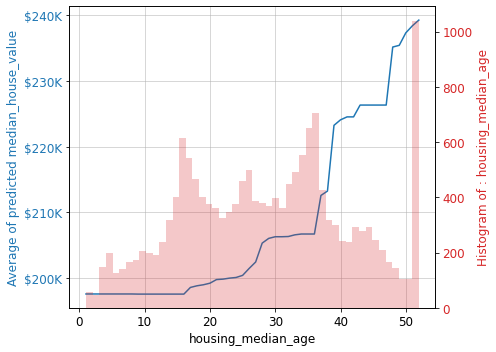

In [66]:
#@title Partial Dependence Plots (PDPs)

#@markdown Select one of the models we trained:
model = "Random Forest" #@param ["Linear Model", "Decision Tree", "Random Forest"]

#@markdown Select which features(s) to visualize (picking **"All"** will plot dependencies for all features, but will take a bit more time):
feature = "housing_median_age" #@param ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '<1H OCEAN', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', "All"]

#@markdown Select which dataset to do the plot in:
dataset = "Training" #@param ['Training', 'Test']

#@markdown <br><br>**Feel free to customize some aspects of the plot**

#@markdown Choose or type the width and height for the figure in inches:
figure_width = "7" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_width=="Auto":
  figure_width=7.0
else:
  figure_width=np.float(figure_width)

figure_height = "5" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_height=="Auto":
  figure_height=5.0
else:
  figure_height=np.float(figure_height)

#@markdown Check the box below if you would like to also see histograms of the feature values overlayed:

#@markdown (This helps you interpret the PDPs more responsibly, as you can understand how representative that feature value is for your data.)

show_histogram = True #@param {type:"boolean"}

print("Your selection:")
print("Model:        {}".format(model))
print("Feature(s):   {}".format(feature))
print("Dataset:      {}".format(dataset))

# select the right model
if model == "Linear Model":
  use_model = linear_model
elif model == "Decision Tree":
  use_model = tree_model
else:
  use_model = rf_model

if feature=="All":
  feature = X_train.columns
else:
  feature = [feature]

# select the right dataset
if dataset=="Training":
  X_data = X_train
else :
  X_data = X_test

partial_dependence_plots(dataset=dataset, model_name=model, model=use_model, \
                         X=X_data, features=feature, target_name='median_house_value', \
                         show_hist=show_histogram, show_density=False, \
                         figsize=(figure_width,figure_height))
                        

Partial dependence plots (PDPs) are powerful tools to help you understand the inner workings on your trained Machine Learning model. To use them responsibly, it is worth knowing both the advantages and disadvantages.

<font color=black>**Advantages:** </font>
1. PDPs are an **intuitive** way to measure dependency: the average prediction if we forced all data points to assume a specific feature value
2. PDPs are **easy to implement**: all that is required is to predict using our model, compute averages and plot
3. PDPs yield a **causal interpretation for the model**: we are examining how changes in just one feature impact the prediction, so this is a causal dependency within the context of the model. (<font color=red>CAUTION: there is **no** causal statement here about real life!</font>)  
4. PDPs are an **acccurate assesssment of dependency** if the plotted features are independent of all other features: in this case, the PDP perfectly interprets how the plotted features influences the prediction on average.

<font color=black>**Disadvantages:** </font>
1. You can visualize **at most two features** at once.  
2. PDPs **assume independence**. We already mentioned this briefly above, but the calculations done with a PDP are guaranteed to be an accurate estimate of impact only when the plotted feature(s) are uncorrelated of other features. (Some other methods are more effective for correlated features, e.g., [Accumulated Local Effect plots](https://christophm.github.io/interpretable-ml-book/ale.html#ale).)  
3. PDPs only capture averages, and thus might **hide heterogeneous effects**. (A potential fix are [Individual Conditional Expectation curves](https://christophm.github.io/interpretable-ml-book/ice.html#ice)).

Some other tools are available to understand dependencies and to quantify the impact of features in **black-box** models. For more details and pointers, please refer to our final section on things left out.

# **9. Things We Are Leaving Out**
Due to the limited class time, our discussion here is far from exhaustive and  is leaving out several important topics. If you are interested in more details, uncomment this section for a brief discussion and a few pointers.

### Avoiding **Sampling Bias** Through **Stratified Sampling**


To understand what this is about, think about running a poll in which you select 1,000 people to ask a specific question. In a well-designed poll, you should ensure that the 1,000 people adequately represent the true demographics. For instance, the proportion of females in your sample is the same as the true proportion of females in the overall population, the proportion across age groups reflects the overall population, etc. This is known as **stratified sampling**: the population is divided into homogenous subgroups (called *strata*), and the right number of instances are sampled from each subgroup to guarantee that the training/test set are representative of the overall population. How we define the strata depends on the context, but generally we want to ensure that the training/test set adequately reflect the distribution of features that are important for predictive purposes.

For a concrete example in the context of our problem, suppose we would like to ensure that the data used to train our algorithms properly represents different **income categories** in the population. Since our `median_income` feature has continuous values, we must first create a discrete set of income categories that will represent our strata. Below, we use the `pandas` function [`cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) to create a new data feature called `income_cat` that records whether the median income in a district falls in one of five income categories.

In [67]:
#@title Create a new categorical feature based on income
# create a new feature that records whether the income falls in one of 5 categories
data["income_cat"] = pd.cut(data["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1, 2, 3, 4, 5])

Let's have a look at the new feature. We will print the first few rows, count the values and plot a histogram.

In [68]:
data.head()

longitude  latitude  ...  ocean_proximity  income_cat
0    -122.23     37.88  ...         NEAR BAY           5
1    -122.22     37.86  ...         NEAR BAY           5
2    -122.24     37.85  ...         NEAR BAY           5
3    -122.25     37.85  ...         NEAR BAY           4
4    -122.25     37.85  ...         NEAR BAY           3

[5 rows x 11 columns]

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64


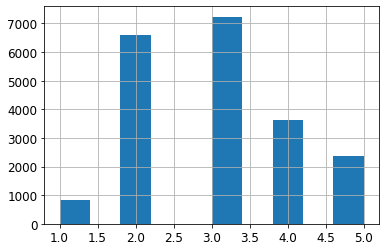

In [69]:
#@markdown Count the number of districts falling in each category
print(data["income_cat"].value_counts())

#@markdown Do a histogram
data["income_cat"].hist()

Let us repeat the original **random sampling** procedure. Note that we are again using the seed of 42, so we should get identical train/test sets as above, but these will now also include the `income_cat` feature. (If you want, feel free to print the first few rows and check!)

In [70]:
# a simple random sampling
random_train_set, random_test_set = train_test_split(data, test_size=0.2, random_state=42)

Now we can use `Scikit-Learn` to do **stratified sampling** based on the income category that we just created.

In [71]:
#@title Do stratified sampling for training/test sets
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

Let's compare the two methods above for obtaining training/test sets to see which is more precise at capturing the proportions of income categories that exist in our original dataset. Below, the columns named `Overall`, `Random` and `Stratified` correspond to the proportions in the **overall** data and in the training set obtained from the **random** sampling and the **stratified** sampling procedures, respectively.

In [72]:
# create a dataframe with columns recording the proportion of income categories in the three datasets  
compare_props = pd.DataFrame({
    "Overall": data["income_cat"].value_counts() / len(data),
    "Random": random_train_set["income_cat"].value_counts() / len(random_train_set),
    "Stratified": strat_train_set["income_cat"].value_counts() / len(strat_train_set)
}).sort_index()
compare_props["% Error Random"] = 100 * (compare_props["Random"] / compare_props["Overall"] - 1)
compare_props["% Error Stratified"] = 100 * (compare_props["Stratified"] / compare_props["Overall"] - 1)

compare_props  # print this out

Overall  Random  Stratified  % Error Random  % Error Stratified
1     0.04    0.04        0.04           -0.24                0.06
2     0.32    0.32        0.32           -0.43                0.00
3     0.35    0.35        0.35           -0.57                0.00
4     0.18    0.18        0.18            1.26               -0.01
5     0.11    0.12        0.11            1.08               -0.03

As you can see above, the error from randomized sampling can be quite large, particularly for certain income categories like 4 and 5. Stratified sampling produces a training set with proportions that are much closer to the original dataset, and helps avoid potential sampling biases.

To conclude our brief discussion, it is also worth noting that **sampling bias may also occur in terms of missing data**: when our dataset has missing values, we would want to make sure that both the training and the test set have missing data in proportions that match those in the entire dataset. Let's see how the random and stratified split were performing from this point of view.

In [73]:
#@title Calculate how many missing entries are in the test set under each way of splitting
print("The original data has {:.2f}% missing entries in the total_bedrooms column."\
      .format( 100 * data["total_bedrooms"].isnull().sum() / len(data)))
print("The train set from the simple random split has {:.2f}% missing entries in the total_bedrooms column."\
      .format( 100 * train_set["total_bedrooms"].isnull().sum() / len(train_set)))
print("The train set from stratified sampling has {:.2f}% missing entries in the total_bedrooms column."\
      .format(100 * strat_train_set["total_bedrooms"].isnull().sum() / len(strat_train_set)))

The original data has 1.00% missing entries in the total_bedrooms column.
The train set from the simple random split has 0.00% missing entries in the total_bedrooms column.
The train set from stratified sampling has 0.96% missing entries in the total_bedrooms column.


As it happens, the random split with a seed of 42 was an **extremely poor** representation of the missing values: the training set had **no** data with missing entries, i.e., all missing rows were placed in the test set! We note that we did **not** choose 42 adversarially here -- rather, we followed the choice in a famous ML book, and by pure chance this results in a very bad split of missing records! Note that the same seed results in a better split for the stratified set, where the proportion is a lot closer to the original set. However, this was pure luck, as we did not correct for the issue explicitly. In practice, it would be better to explicitly check for this by creating a strata based on the missing entries as well.

<font color=red>**Balance sampling bias with snooping bias.**</font> Although stratified sampling has some important advantages over purely random sampling, it also poses a potentially serious pitfall: it may introduce a certain degree of "data snooping" bias, because we are **using the entire dataset** and also **specific features** to define what are the important strata and to judge the training/test sets. In practice it is important to not "overdo" this, and to remember that there should be a balance between sampling and snooping bias.

In [74]:
# drop the new income category from the original dataset
data.drop("income_cat", axis=1, inplace=True)

### **Feature Engineering**

In order to improve prediction in practical problems, one must often resort to introducing new features that are **derived** from the initial data. This  critical step of the ML pipeline is referred to as **feature engineering**, and is a combination of art and science, as domain knowledge can be critical when it comes to deriving meaningful features. In fact, experience suggests that this step is often **more important** in improving prediction than the specific algorithms used!

To understand what this is about in a more concrete example, you may recall from our Exploratory Data Analysis that several features in our data were not strongly correlated with the `median_house_value` target, despite our intuition that they should be meaningful. Two such examples were `total_bedrooms` and `total_rooms`: both calculated as **totals per district**, so were not as  informative of house value. But perhaps by considering some **derived** features such as the number of **rooms_per_household** or the number of **rooms_per_bedroom**, we could improve the predictions of our model, and even make its features more relevant. 

In fact, we can quickly confirm that this might be the case by calculating these new features and their correlations with the target.

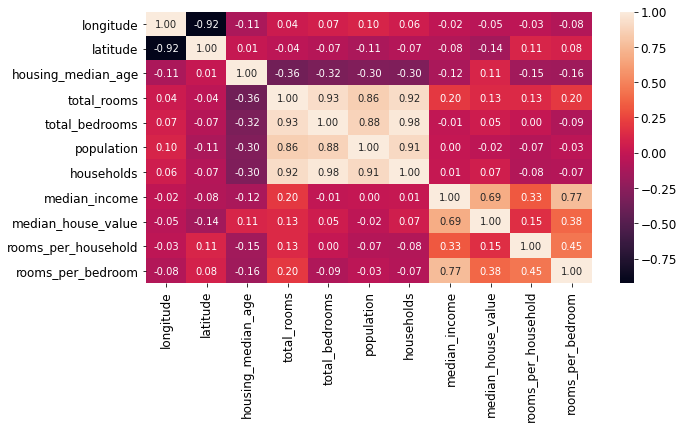

In [75]:
#@title Derive some new features and calculate the correlation matrix
data["rooms_per_household"] = data["total_rooms"]/data["households"]
data["rooms_per_bedroom"] = data["total_rooms"]/data["total_bedrooms"]

new_corr_matrix = data.corr()
plt.figure(figsize = (10,5));
sns.heatmap(new_corr_matrix, annot=True, fmt=".2f")
plt.show()

Note that the new features `rooms_per_household` (calculated as the ratio of `total_rooms` and `households`) and `rooms_per_bedroom` (calculated as the ration of `total_bedrooms` and `total_rooms`) are now more correlated with our `median_house_value` target than the simpler features we started off with, so including them may improve the accuracy of our models.

### Calibrating **hyper-parameters**

You may recall that when we created the decision tree and the random forest models, there were several **hyper-parameters** that we could specify, such as for instance `max_depth`. These values are very important in practice, and can critically drive the performance of our ML algorithms in new data (as our brief discussion of overfitting hopefully convinced you.) 

There is a systematic way to search for hyper-parameter values using a technique called **cross-validation**, and modern R or Python packages have automatic implementations that enable you to accomplish this. For instance, [here](https://scikit-learn.org/stable/modules/cross_validation.html) a description for the SciKit Learn Python package. 

### Changing the **measure of accuracy** to reflect other business KPIs

In practice, you may want more flexibility when defining the performance metrics of your ML model. For instance, instead of simply judging predictive accuracy using `mse`, you may want to define your own scoring rule. This is particularly important if you have an idea of **how the ML model will be used subsequently**, since you may be able to capture the relevant business KPIs much better. Some modern packages allow you to do this by changing the scoring function used during training; for instance, [here](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)  is a description for SciKitLearn. 


### More Advanced Tools for **Interpretability**

In business contexts, the ability to explain and interpret ML models is key to adoption. We discussed some ways to do this through **visualizations** and **partial dependence plots**, but other methods and tools have been especially designed for this purpose. Examples include:
* computing **local surrogates** to explain specific predictions in your model. The idea here is that in order to explain why your model is predicting in a certain way for a specific sample/datapoint, you can perturb the point, calculate predictions for the slightly perturbed sample(s), and fit some simpler interpretable models to those predictions. Implementations are available for this idea in both R and Python (for more details, see [this](https://christophm.github.io/interpretable-ml-book/lime.html)).
* computing **Shapley values** for your model. This is a slightly different way to explain how your model reaches predictions and to quantify the importance of features, based on ideas from economics. Both R and Python implementations exist (for details, see [this](https://christophm.github.io/interpretable-ml-book/shapley.html#disadvantages-13)). We include a quick example using [SHAP](https://github.com/slundberg/shap) Python implementation below, to show you the kinds of things that are possible.


#### Using **SHAP** to Explain Complex Models

We will use [SHAP](https://github.com/slundberg/shap) to explain individual predictions for a random forest model.

In [76]:
#@title import shap library
!pip install shap &> /dev/null
import shap

#@markdown Train a **Random Forest** model with the first 1000 samples from our training data

##@markdown Select how many samples to use in training:
#num_samp = "500" #@param [500, 1000, 2000]
num_samp = 1000  # first 1000 samples of the training set

small_rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=42, oob_score=True)

num_samp = min(1000, len(X_train.index))
small_X_train = X_train.iloc[0:num_samp,:]
small_y_train = y_train[0:num_samp]
small_rf_model.fit(small_X_train, small_y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [77]:
#@markdown Select a sample to visualize:
sample = 49 #@param {type:"slider", min:0, max:1000, step:1}

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(small_rf_model)
shap_values = explainer.shap_values(small_X_train)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample,:], small_X_train.iloc[sample,:])

**Interpretation**. The plot above shows how each feature is contributing to push the model output from a specific **base value** (equal to the **average predicted target** over the entire training dataset) to the actual model output **for a given sample**. Features pushing the prediction higher are shown in red and those pushing the prediction lower are in blue. These types of plots are called **force_plots**, because each feature is depicted like a force pushing the model output in a specific direction.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset as shown below. The following plot is interactive. Just scroll the mouse and see the different values.

In [78]:
#@title Visualize the SHAP Explanations in the Entire Training Set
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, small_X_train)

We can also compute the **importance** of each feature, i.e., a measure of how much each feature contributes to driving the model output; this is calculated **on average**, over the entire training set.

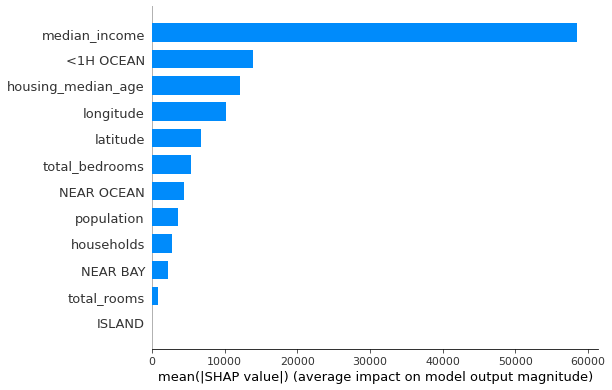

In [79]:
#@title Compute the feature importance
shap_values = shap.TreeExplainer(small_rf_model).shap_values(small_X_train)
shap.summary_plot(shap_values, small_X_train, plot_type="bar")

We can also get more actionable information by looking at a SHAP **summary plot**. This combines feature importance with feature effects, and is done with the points in the training data. It demonstrates the following information:
 - *Feature importance*: Variables are ranked in descending order.
 - *Impact*: The horizontal location shows whether the impact of the variable is associated with a higher or lower prediction in each sample.
 - *Correlations*: You can assess the magnitude and direction of the correlations between features and the predicted value through the color and location of points on the X-axis. 

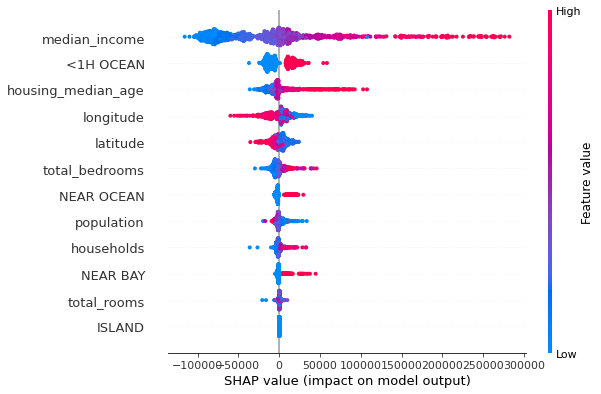

In [80]:
#@title Create a SHAP Summary Plot
shap.summary_plot(shap_values, small_X_train)

Lastly, we can use SHAP to do a **Dependence Plot**. This is a generalization of the partial dependence plots we saw earlier, and it shows the marginal effect one or two features on the predicted outcome in every sample. Using it, we can assess whether the relationship between the target and features is linear, monotonic or more complex. 

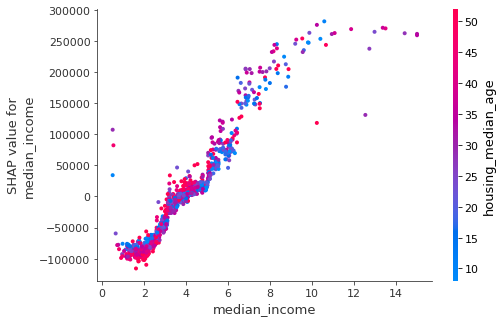

In [81]:
#@title Create a SHAP Dependence Plot

#@markdown Select which feature to visualize: <br>
#@markdown (the function will automatically includes another feature that the chosen feature interacts most with)
feature = "median_income" #@param ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

shap.dependence_plot(feature, shap_values, small_X_train)

# **10. References**
If you would like to learn more about some of the topics covered here, the following are a great set of resources:
 - [An Introduction to Statistical Learning with Applications in R](https://www.springer.com/gp/book/9781461471370) by Gareth James, Daniela Witten, Trevor Hastie and Rob Tibshirani. Excellent and very accesible reference for conceptual elements + implementation in R.
 - [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) by Aurélien Géron. Great reference for Machine Learning in Python, primarily on the coding and implementation side.
 - [Interpretable ML Book: A Guide to Making Black-Box Models Interpretable](https://christophm.github.io/interpretable-ml-book/) by Christoph Molnar. Great reference for going deeper on the topic of Interpretable Machine Learning.